# Notebook Patterns


## Data

In [1]:
!pip install awswrangler

In [2]:
import awswrangler as wr
import boto3

mybucket = 'dlocal-eu1-office-live-sagemaker-jcamuyrano'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import decimal
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
query = '''

Select 

risk.case_id,
risk.country_code,
m.merchant_name,
risk.merchant_reference,
risk.month,
extract(week from risk.created_date) as week,
risk.day,

risk.created_date,
cast(risk.created_date as date) as "date",
risk.ticket_id,
risk.payment_id,
risk.card_id,
risk.operation_name,
risk.operation_type,

risk.user_document_type,
risk.operation_name,
risk.user_email,
risk.user_email_text,
risk.user_domain,
risk.user_name,
risk.user_document,
risk.user_ip,
risk.user_cookie,
risk.user_reference,

risk.description,
risk.user_phone,
risk.user_birthdate,
risk.billing_address,
risk.billing_street,
risk.billing_number,
risk.billing_city,
risk.billing_state,
risk.billing_postal_code,
risk.device_id,

card.hash,
card.bin as card_bin,
card.country as card_country,
card.brand as card_brand,
card.category as card_category,
card.region as card_region,
card.type as card_type,
card.bank as card_bank,

ip.location_country_code,
ip.location_country_name,
ip.location_region_name,
ip.location_city_name,
ip.user_ip_num,


cast(cbk.date_created as date) as cbk_date,
date_diff('day',risk.created_date,cbk.date_created) as cbk_notif,


cc.result,
cc.reason,
risk.online_verdict_reason,
-- risk.online_verdict_tags,
-- risk.payment_method_code,


risk.usd_amount,
risk.online_verdict,

-- Other tags

case when lower(risk.online_verdict_tags) like '%pos_user_lvl1_5m%' then 'Positive History - Mature' 
     when lower(risk.online_verdict_tags) like '%pos_user_lvl2_5m%' then 'Positive History - Mature'
     when lower(risk.online_verdict_tags) like '%super_positive_5m%' then 'Positive History - Mature'
     when lower(risk.online_verdict_tags) like '%pos_user_lvl1_3m%' then 'Positive History - Mature' 
     when lower(risk.online_verdict_tags) like '%pos_user_lvl2_3m%' then 'Positive History - Mature'
     when lower(risk.online_verdict_tags) like '%super_positive_3m%' then 'Positive History - Mature'
     when lower(risk.online_verdict_tags) like '%pos_user_lvl1_1m%' then 'Positive History - Recent' 
     when lower(risk.online_verdict_tags) like '%pos_user_lvl2_1m%' then 'Positive History - Recent'
     when lower(risk.online_verdict_tags) like '%pos_user_lvl3_1m%' then 'Positive History - Recent'
     when lower(risk.online_verdict_tags) like '%super_positive_1m%' then 'Positive History - Recent'
     when lower(risk.online_verdict_tags) like '%pos_user%' then 'Positive Others'
     else 'No Positive' end as positive_user,
     
case 
when (lower(risk.online_verdict_reason)='default' and lower(risk.online_verdict)='accept') THEN 'Default'
when (lower(risk.online_verdict_reason) like '%positive%' and (lower(risk.online_verdict_reason) like '%super%'
                                                        or lower(risk.online_verdict_reason) like '%lvl 1%'
                                                        or lower(risk.online_verdict_reason) like '%lvl 2%') 
                                                        and lower(risk.online_verdict)='accept') THEN 'Positive history'
when (lower(risk.online_verdict_reason) like '%positive%' and lower(risk.online_verdict)='accept' and lower(risk.online_verdict_reason) not like '%gaming sift model%') THEN 'Positive others'
when ((lower(risk.online_verdict_reason) like '%model%' or lower(risk.online_verdict_reason)='boacompra garena positives')and lower(risk.online_verdict)='accept') THEN 'Positive ML rules'
when (lower(risk.online_verdict_reason) like '%test%') THEN 'Test'
when (lower(risk.online_verdict)= 'accept') THEN 'Other accept'
when (lower(risk.online_verdict_reason) like '%risk limit%') THEN 'Risk limit'
when (lower(risk.online_verdict_reason) like '%negative list%' and lower(risk.online_verdict)='reject') THEN 'Negative list'
when (lower(risk.online_verdict_reason) like '%negative list%' and lower(risk.online_verdict)='reject') THEN 'Negative list'
when (lower(risk.online_verdict_reason) like '%generic -%' and lower(risk.online_verdict)='reject') THEN 'Previous chargeback'
when (lower(risk.online_verdict_reason) like '%sift%gt%' and lower(risk.online_verdict)='reject') THEN 'Sift Score reject'
when (lower(risk.online_verdict_reason) like '%model%' and lower(risk.online_verdict)='reject') THEN 'ML Score reject'
when (lower(risk.online_verdict_reason) like '%specific -%' and lower(risk.online_verdict)='reject') THEN 'Specific rules'
when (lower(risk.online_verdict_reason) like '%ekata%' and lower(risk.online_verdict)='reject') THEN 'Ekata'
when (lower(risk.online_verdict_reason) like '%ea -%' and lower(risk.online_verdict)='reject') THEN 'Emailage'
when (lower(risk.online_verdict_reason) like '%business rule%' and lower(risk.online_verdict)='reject') THEN 'Business rule'
when (lower(risk.online_verdict_reason) like '%gaming sift all - same%' and lower(risk.online_verdict)='reject') THEN 'Velocities gaming soft'
when (lower(risk.online_verdict_reason) like '%gaming sift br mx - same%' and lower(risk.online_verdict)='reject') THEN 'Velocities gaming hard'
when (lower(risk.online_verdict_reason) like '% sift - %' and lower(risk.online_verdict)='reject') THEN 'Merchant velocities'
when (lower(risk.online_verdict)='reject') THEN 'Other reject'
else 'Not defined' end as rule_type,


--BINS

-- SIFT

case when sift.payment_abuse_score*100 is null then 9999
     when sift.payment_abuse_score*100<=5 then 5
     when sift.payment_abuse_score*100<=10 then 10
     when sift.payment_abuse_score*100<=15 then 15
     when sift.payment_abuse_score*100<=20 then 20
     when sift.payment_abuse_score*100<=30 then 30
     when sift.payment_abuse_score*100<=40 then 40
     when sift.payment_abuse_score*100<=50 then 50
     when sift.payment_abuse_score*100<=60 then 60
     when sift.payment_abuse_score*100<=70 then 70
     when sift.payment_abuse_score*100<=75 then 75
     when sift.payment_abuse_score*100<=80 then 80
     when sift.payment_abuse_score*100<=81 then 81
     when sift.payment_abuse_score*100<=82 then 82
     when sift.payment_abuse_score*100<=83 then 83
     when sift.payment_abuse_score*100<=84 then 84
     when sift.payment_abuse_score*100<=85 then 85
     when sift.payment_abuse_score*100<=86 then 86
     when sift.payment_abuse_score*100<=87 then 87
     when sift.payment_abuse_score*100<=88 then 88
     when sift.payment_abuse_score*100<=89 then 89
     when sift.payment_abuse_score*100<=90 then 90
     when sift.payment_abuse_score*100<=91 then 91
     when sift.payment_abuse_score*100<=92 then 92
     when sift.payment_abuse_score*100<=93 then 93
     when sift.payment_abuse_score*100<=94 then 94
     when sift.payment_abuse_score*100<=95 then 95
     when sift.payment_abuse_score*100<=96 then 96
     when sift.payment_abuse_score*100<=97 then 97
     when sift.payment_abuse_score*100<=98 then 98
     when sift.payment_abuse_score*100<=99 then 99
     when sift.payment_abuse_score*100<=100 then 100
     else null end as bin_sift,

--MACHINE LEARNING

case when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) is null then 9999
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 1 then 1
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 1 then 1
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 5 then 5
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 10 then 10
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 15 then 15
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 20 then 20
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 25 then 25
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 30 then 30
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 35 then 35
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 40 then 40
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 45 then 45
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 50 then 50
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 55 then 55
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 60 then 60
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 65 then 65
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 70 then 70
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 75 then 75
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 80 then 80
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 85 then 85
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 90 then 90
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 95 then 95
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 100 then 100
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 110 then 110
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 120 then 120
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 130 then 130
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 140 then 140
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 150 then 150
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 180 then 180
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 200 then 200
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 250 then 250
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 300 then 300
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 400 then 400
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 500 then 500
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 800 then 800
     when coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) <= 1000 then 1000
     else null end as bin_ml,    

-- AMOUNT

case when risk.usd_amount is null then 0
     when risk.usd_amount <= 1 then 1
     when risk.usd_amount <= 5 then 5
     when risk.usd_amount <= 10 then 10
     when risk.usd_amount <= 15 then 15
     when risk.usd_amount <= 20 then 20
     when risk.usd_amount <= 25 then 25
     when risk.usd_amount <= 30 then 30
     when risk.usd_amount <= 35 then 35
     when risk.usd_amount <= 40 then 40
     when risk.usd_amount <= 45 then 45
     when risk.usd_amount <= 50 then 50
     when risk.usd_amount <= 55 then 55
     when risk.usd_amount <= 60 then 60
     when risk.usd_amount <= 65 then 65
     when risk.usd_amount <= 75 then 75
     when risk.usd_amount <= 100 then 100
     when risk.usd_amount <= 150 then 150
     when risk.usd_amount <= 200 then 200
     when risk.usd_amount <= 300 then 300
     when risk.usd_amount <= 400 then 400
     when risk.usd_amount <= 500 then 500
     when risk.usd_amount <= 700 then 700
     when risk.usd_amount <= 1000 then 1000
     when risk.usd_amount <= 2000 then 2000
     else 9999 end as bin_amount,

cbk.date_created as cbk_date_created,

case when risk.online_verdict='ACCEPT' then 1 else 0 end flag_app_pf,
case when cc.result='ACCEPT' then 1 else 0 end flag_app_final,

case when risk.online_verdict='ACCEPT' then usd_amount else 0 end app_pf_amt,
case when cc.result='ACCEPT' then risk.usd_amount else 0 end app_final_amt,

(case when cc.result='ACCEPT' and cbk.id_chargeback is not null then 1 else 0 end) cbk_flag,

(case when cc.result='ACCEPT' and cbk.id_chargeback is not null and date_diff('day',risk.created_date,cbk.date_created) <= 30 then 1 else 0 end) cbk_flag_30_days,
(case when cc.result='ACCEPT' and cbk.id_chargeback is not null then usd_amount else 0 end) cbk_amt,
(case when cc.result='ACCEPT' and cbk.id_chargeback is not null and date_diff('day',risk.created_date,cbk.date_created) <= 30 then usd_amount else 0 end) cbk_amt_30_days,


cast((sift.payment_abuse_score)*100 as double) as sift_score,

round(cast(coalesce(ml.data_output_output_val_result_class_1, ml1.pred_score) as double),2) as inhouse_score

from risk.risk_risk_case risk

left join risk.risk_sift_response sift 
    on risk.case_id = sift.risk_case_id 
    and sift."year" = '2021' 
    and sift."month" in ('8','9','10','11','12')

left join datalake_lookout.machine_learning_details ml 
    on risk.case_id = ml.data_input_input_val_caseid 
    and ml."year" = '2021' 
    and ml."month" in ('8','9','10','11','12')

left join "dlocal-eu1-office-live-machine-learning"."saas_test_dataset_original" ml1 
    on risk.case_id = ml1.case_id

left join default.merchant_data_pf m 
    on risk.merchant_reference=m.merchant_reference 
    and risk.country_code = m.country_code
    
left join risk.risk_risk_case_collect cc 
    on risk.case_id=cc.case_id and cc."year" = '2021' 
    and cc."month" in ('8','9','10','11','12')

left join dl_db_master.unipay_chargebacks cbk 
    on risk.ticket_id=cbk.id_boleto 
    and cc.result='ACCEPT' and cbk."year" in ('2021','2022')

left join risk.risk_card card 
    on risk.card_id = card.card_id
    
left join "dlocal_eu1_office_live_silver_external"."risk_case_enriched" ip 
    on cast(risk.case_id as int) = cast(ip.case_id as int) 
    and ip."year" = '2021' 
    and ip."month" in ('8','9','10','11','12')

where 1=1
    and risk."year" = '2021'
    and risk."month" in ('8','9','10','11','12')
    and risk.operation_type IN ('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
    and risk.merchant_reference IN ('29641')

'''

In [5]:
%%time

df_original = wr.athena.read_sql_query(
    sql=query,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-jcamuyrano/dev'
)

CPU times: user 6.65 s, sys: 281 ms, total: 6.93 s
Wall time: 54.4 s


In [6]:
df_original['case_id'] = df_original.case_id.astype(str)

print('shape --->', df_original.shape)
print('')
print(df_original.info())

shape ---> (102246, 70)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102246 entries, 0 to 102245
Data columns (total 70 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   case_id                102246 non-null  object        
 1   country_code           102246 non-null  string        
 2   merchant_name          102246 non-null  string        
 3   merchant_reference     102246 non-null  string        
 4   month                  102246 non-null  string        
 5   week                   102246 non-null  Int64         
 6   day                    102246 non-null  string        
 7   created_date           102246 non-null  datetime64[ns]
 8   date                   102246 non-null  object        
 9   ticket_id              102223 non-null  Int64         
 10  payment_id             102246 non-null  string        
 11  card_id                102246 non-null  Int32         
 12  operation_name     

In [7]:
sql_sherlock = '''

select * 

from (
select 

risk.case_id,

-- Velocities

(coalesce(cardinality(filter(transform(siv.same_card.same_card.total.transaction_hours, x -> cast(x as int)), x -> x < 24)), 0)) as same_card_1d,
(coalesce(cardinality(filter(transform(siv.same_card.same_card.total.transaction_hours, x -> cast(x as int)), x -> x < 168)), 0)) as same_card_7d,
(coalesce(cardinality(filter(transform(siv.same_card.same_card.total.transaction_hours, x -> cast(x as int)), x -> x < 720)), 0)) as same_card_30d,

(coalesce(cardinality(filter(transform(siv.same_email.same_email.total.transaction_hours, x -> cast(x as int)), x -> x < 24)), 0)) as same_email_1d,
(coalesce(cardinality(filter(transform(siv.same_email.same_email.total.transaction_hours, x -> cast(x as int)), x -> x < 168)), 0)) as same_email_7d,
(coalesce(cardinality(filter(transform(siv.same_email.same_email.total.transaction_hours, x -> cast(x as int)), x -> x < 720)), 0)) as same_email_30d,

(coalesce(cardinality(filter(transform(siv.same_card.same_card.approved.transaction_hours, x -> cast(x as int)), x -> x < 24)), 0)) as same_card_1d_app,
(coalesce(cardinality(filter(transform(siv.same_card.same_card.approved.transaction_hours, x -> cast(x as int)), x -> x < 168)), 0)) as same_card_7d_app,
(coalesce(cardinality(filter(transform(siv.same_card.same_card.approved.transaction_hours, x -> cast(x as int)), x -> x < 720)), 0)) as same_card_30d_app,

row_number() over (partition by case_id order by (array_max(transform(siv.same_card.same_card.total.transaction_hours, x -> cast(x as int)))) desc) as orden

from risk.risk_risk_case as risk

left join "datalake_lookout"."sherlock_initial" si 
    on cast(risk.case_id as varchar) = si."data.input.transaction.case_id" 
    and si."year"='2021' 
    and si."month" in ('8','9','10','11','12')

left join "datalake_lookout"."sherlock_initial_velocities" siv 
    on siv.sherlock_initial_id = si.id 
    and siv."year"='2021' 
    and siv."month" in ('8','9','10','11','12')

where 1=1
    and risk."year" = '2021'
    and risk."month" in ('8','9','10','11','12')
    and risk.operation_type IN ('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
    and risk.merchant_reference IN ('29641')
    and ((array_max(transform(siv.same_card.same_card.total.transaction_hours, x -> cast(x as int)))) is not null
or (array_max(transform(siv.same_email.same_email.total.transaction_hours, x -> cast(x as int)))) is not null)
)
where orden=1

'''

In [8]:
%%time

df_sherlock = wr.athena.read_sql_query(
    sql=sql_sherlock,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-jcamuyrano/dev'
)

CPU times: user 32.3 s, sys: 932 ms, total: 33.2 s
Wall time: 8min 16s


In [9]:
df_sherlock['case_id'] = df_sherlock.case_id.astype(str)

print('shape --->', df_sherlock.shape)
print('')
print(df_sherlock.info())

shape ---> (99042, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99042 entries, 0 to 99041
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   case_id            99042 non-null  object
 1   same_card_1d       99042 non-null  Int64 
 2   same_card_7d       99042 non-null  Int64 
 3   same_card_30d      99042 non-null  Int64 
 4   same_email_1d      99042 non-null  Int64 
 5   same_email_7d      99042 non-null  Int64 
 6   same_email_30d     99042 non-null  Int64 
 7   same_card_1d_app   99042 non-null  Int64 
 8   same_card_7d_app   99042 non-null  Int64 
 9   same_card_30d_app  99042 non-null  Int64 
 10  orden              99042 non-null  Int64 
dtypes: Int64(10), object(1)
memory usage: 9.3+ MB
None


In [10]:
cage_sql = '''

SELECT 

main.hash,
cage.min_date_approved as hash_min_date_approved,
cage.min_date_attempt as hash_min_date_total


FROM (

  select distinct card.hash
  from risk.risk_risk_case risk
  left join risk.risk_card card on risk.card_id = card.card_id

  where 1=1
  and risk."year" = '2021'
  and risk."month" in ('8','9','10','11','12')
  and risk.operation_type IN ('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
  and risk.merchant_reference IN ('29641')
  
     ) main


LEFT JOIN (
  
    SELECT 
        crd.hash,
        min(case when cc.result='ACCEPT' then RC.created_date else null end) as min_date_approved,
        min(RC.created_date) as min_date_attempt
  
    FROM risk.risk_risk_case AS RC
    
    JOIN risk.risk_card crd 
        ON RC.card_id = crd.card_id
        
    LEFT JOIN risk.risk_risk_case_collect cc 
        on RC.case_id=cc.case_id 
        and cc."year" in ('2021','2020','2019')
  
    WHERE 1 = 1
        AND RC.year in ('2021','2020','2019')
    
    group by crd.hash
          ) AS cage on main.hash=cage.hash
          
'''

In [11]:
eage_sql = '''

SELECT 

main.user_email,
eage.min_date_approved as email_min_date_approved,
eage.min_date_attempt as email_min_date_total


FROM (

  select distinct risk.user_email
  
  from risk.risk_risk_case risk

  where 1=1
      and risk."year" = '2021'
      and risk."month" in ('8','9','10','11','12')
      and risk.operation_type IN ('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
      and risk.merchant_reference IN ('29641')
  
     ) main


LEFT JOIN (
  
    SELECT 
        rc.user_email,
        min(case when cc.result='ACCEPT' then RC.created_date else null end) as min_date_approved,
        min(RC.created_date) as min_date_attempt
  
    FROM risk.risk_risk_case AS RC
    
    LEFT JOIN risk.risk_risk_case_collect cc 
        on RC.case_id=cc.case_id 
        and cc."year" in ('2021','2020','2019')
  
    WHERE 1 = 1
        AND RC.year in ('2021','2020','2019')
    
    group by rc.user_email
          ) AS eage on main.user_email=eage.user_email
          
'''

In [12]:
%%time

df_cage = wr.athena.read_sql_query(
    sql=cage_sql,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-jcamuyrano/dev'
)

CPU times: user 2.56 s, sys: 85.3 ms, total: 2.64 s
Wall time: 36.2 s


In [13]:
%%time

df_eage = wr.athena.read_sql_query(
    sql=eage_sql,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-jcamuyrano/dev'
)

CPU times: user 2.14 s, sys: 54.8 ms, total: 2.19 s
Wall time: 30.6 s


In [14]:
print('shape --->', df_cage.shape)
print('shape --->', df_eage.shape)

shape ---> (31096, 3)
shape ---> (28972, 3)


## Join all the DFs in one

In [15]:
df_merge = df_original.merge(df_sherlock, how = 'left', on = 'case_id')
df_merge = df_merge.merge(df_cage, how = 'left', on = 'hash')
df_merge = df_merge.merge(df_eage, how = 'left', on = 'user_email')

In [16]:
print('shape --->', df_merge.shape)
print('')
print(df_merge.info())

shape ---> (102246, 84)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102246 entries, 0 to 102245
Data columns (total 84 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   case_id                  102246 non-null  object        
 1   country_code             102246 non-null  string        
 2   merchant_name            102246 non-null  string        
 3   merchant_reference       102246 non-null  string        
 4   month                    102246 non-null  string        
 5   week                     102246 non-null  Int64         
 6   day                      102246 non-null  string        
 7   created_date             102246 non-null  datetime64[ns]
 8   date                     102246 non-null  object        
 9   ticket_id                102223 non-null  Int64         
 10  payment_id               102246 non-null  string        
 11  card_id                  102246 non-null  Int32      

## Delete previous DFs

In [17]:
del df_original
del df_sherlock
del df_cage
del df_eage

## Preprocessing

In [26]:
df = df_merge.copy()

In [27]:
df =  df.dropna(axis = 0, subset= ['online_verdict'])
df['card_country'] = df['card_country'].fillna('Nulo')

def remove_chars_from_score(text):
    import re
    #pattern = r'([^\d,\.]+)'
    pattern = r'([^-,^\d,\.]+)'
    result = re.sub(pattern, '', str(text))
    return result

df['inhouse_score'] = df['inhouse_score'].apply(remove_chars_from_score)


df['inhouse_score'] = df['inhouse_score'].replace('', np.nan)
# df['sift_score'] = df['sift_score'].replace(np.nan, -1.0)

df['sift_score'] = df.sift_score.astype('float')
df['inhouse_score'] = df.inhouse_score.astype('float')

df['usd_amount'] = df.usd_amount.astype('float')
df['app_pf_amt'] = df.app_pf_amt.astype('float')
df['month'] = df.month.astype('int')
df['day'] = df.day.astype('int')
df['app_final_amt'] = df.app_final_amt.astype('float')
df['cbk_amt'] = df.cbk_amt.astype('float')
df['cbk_amt_30_days'] = df.cbk_amt_30_days.astype('float')

In [28]:
df['flag_foreign_card'] = np.where((df['country_code'] != df['card_country']) & (df['card_country'] != 'Nulo'), 1, 0)

In [29]:
def resumen_merchant(merchant_reference, mes_inicial, mes_final,country, dataframe=df):
    
    
    if (country=='all'):
         mask = (dataframe['month'] >= mes_inicial) & (dataframe['month'] <= mes_final) & (dataframe['merchant_reference'].isin(merchant_reference))
                
    else:
         mask = (dataframe['month'] >= mes_inicial) & (dataframe['month'] <= mes_final) & (dataframe['merchant_reference'].isin(merchant_reference)) & (dataframe['country_code'] == str(country))
    
    df_resumen = dataframe[(mask)].groupby(['merchant_name','month']).agg({
        'case_id': 'count', #count de las trx
        'usd_amount': np.sum,
        'flag_app_pf': np.sum, # cantidad aprob dlocal
        'app_pf_amt': np.sum, # monto aprob dlocal
        'flag_app_final': np.sum, # cantidad aprob final
        'app_final_amt': np.sum, # monto aprob final
        'cbk_flag': np.sum,
        'cbk_amt': np.sum,
        'cbk_amt_30_days': np.sum,
        'cbk_flag_30_days': np.sum
    })

    df_agrup = df_resumen.sort_values(['merchant_name','month'], ascending = (True,False))
    
    #df_agrup.columns = ['trx_qty', 'trx_amt', 'aprob_dlocal_qty', 'aprob_final_qty', 'cbk_qty', 'cbk_amt', 'positive_app_qty']
    df_agrup.columns = ['trx_qty', 'trx_amt', 'app_dlocal_qty', 'app_dlocal_amt', 'app_final_qty', 'app_final_amt', 'cbk_qty', 'cbk_amt','cbk_amt_30_days','cbk_qty_30_days']

    # df_agrup['pct_prules_dlocal_app'] = df_agrup['positive_app_qty']*(100) / df_agrup['app_dlocal_qty']
    
    # Metricas en QTY
    df_agrup['app_dlocal'] = df_agrup['app_dlocal_qty']*(100) / df_agrup['trx_qty']
    df_agrup['app_final'] = df_agrup['app_final_qty']*(100) / df_agrup['trx_qty']
    df_agrup['cbk_ratio'] = df_agrup['cbk_qty']*(100) / df_agrup['app_final_qty']
    df_agrup['cbk_ratio_30d'] = df_agrup['cbk_qty_30_days']*(100) / df_agrup['app_final_qty']
    
    # Metricas en AMT
    df_agrup['app_dlocal_amtr'] = df_agrup['app_dlocal_amt']*(100) / df_agrup['trx_amt']
    df_agrup['app_final_amtr'] = df_agrup['app_final_amt']*(100) / df_agrup['trx_amt']
    df_agrup['cbk_ratio_amt_30d'] = df_agrup['cbk_amt_30_days']*(100) / df_agrup['app_final_amt']
    df_agrup['cbk_ratio_amt'] = df_agrup['cbk_amt']*(100) / df_agrup['app_final_amt']
    
    # Otras Métricas
    
    df_agrup['ticket_avg'] = df_agrup['trx_amt'] / df_agrup['trx_qty']
    df_agrup['cbk_avg'] = df_agrup['cbk_amt'] / df_agrup['cbk_qty']
    
    return df_agrup[['trx_qty','trx_amt','app_dlocal','app_final','app_dlocal_amtr','app_final_amtr','cbk_qty','cbk_ratio','cbk_ratio_amt','cbk_ratio_30d','cbk_ratio_amt_30d','ticket_avg','cbk_avg']].style.applymap(lambda v: 'color:red' if (v > 2.0) else None, subset=['cbk_ratio', 'cbk_ratio_amt', 'cbk_ratio_amt_30d'])


In [30]:
#Convertir primera columna en formato date

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['creation_date'] = pd.to_datetime(df['created_date'],format='%Y-%m-%d %H:%M:%S')
df['month'] = pd.DatetimeIndex(df['date']).month

In [31]:
# Calcular age de card y email
df['card_age_tot']= (df['created_date'] - df['hash_min_date_total']).astype('timedelta64[m]')
df['email_age_tot']= (df['created_date'] - df['email_min_date_total']).astype('timedelta64[m]')

df['card_age_app']= (df['created_date'] - df['hash_min_date_approved']).astype('timedelta64[m]')
df['email_age_app']= (df['created_date'] - df['email_min_date_approved']).astype('timedelta64[m]')


In [32]:
#Pasar age a días
df['card_age_totday'] = (df['card_age_tot']/(60*24)).fillna(0).apply(np.ceil)
df['email_age_totday'] = (df['email_age_tot']/(60*24)).fillna(0).apply(np.ceil)

df['card_age_appday'] = (df['card_age_app']/(60*24)).fillna(0).apply(np.ceil)
df['email_age_appday'] = (df['email_age_app']/(60*24)).fillna(0).apply(np.ceil)

In [33]:
#bins card age

def agrupar_card_age():
    
    values_list_card = [0, 7, 15, 30, 90, 180, 360, 999999]

    conditions_card = []

    for i in values_list_card:
        if i == 0:
            condicion = ((df['card_age_totday'].fillna(0)) == 0)
            conditions_card.append(condicion)
        else:
            condicion = ((df['card_age_totday'].fillna(0)) < i)
            conditions_card.append(condicion)

    df['card_age_bin'] = np.select(conditions_card, values_list_card)
    
agrupar_card_age()

In [34]:
#bins email age

def agrupar_email_age():
    
    values_list_email = [0, 7, 15, 30, 90, 180, 360, 999999]

    conditions_email = []

    for i in values_list_email:
        if i == 0:
            condicion = (df['email_age_totday'] == 0)
            conditions_email.append(condicion)
        else:
            condicion = (df['email_age_totday'] < i)
            conditions_email.append(condicion)

    df['email_age_bin'] = np.select(conditions_email, values_list_email)
    
agrupar_email_age()

In [35]:
#bins email age

def agrupar_email_age():
    
    values_list_email = [0, 7, 15, 30, 90, 180, 360, 999999]

    conditions_email = []

    for i in values_list_email:
        if i == 0:
            condicion = (df['email_age_appday'] == 0)
            conditions_email.append(condicion)
        else:
            condicion = (df['email_age_appday'] < i)
            conditions_email.append(condicion)

    df['email_age_bin_app'] = np.select(conditions_email, values_list_email)
    
agrupar_email_age()

In [36]:
#bins card age

def agrupar_card_age():
    
    values_list_card = [0, 7, 15, 30, 90, 180, 360, 999999]

    conditions_card = []

    for i in values_list_card:
        if i == 0:
            condicion = ((df['card_age_appday'].fillna(0)) == 0)
            conditions_card.append(condicion)
        else:
            condicion = ((df['card_age_appday'].fillna(0)) < i)
            conditions_card.append(condicion)

    df['card_age_bin_app'] = np.select(conditions_card, values_list_card)
    
agrupar_card_age()

In [37]:
df['same_card_30d'] = df['same_card_30d'].fillna(0)
df['same_card_7d'] = df['same_card_7d'].fillna(0)
df['same_card_1d'] = df['same_card_1d'].fillna(0)
df['same_card_30d_app'] = df['same_card_30d'].fillna(0)
df['same_card_7d_app'] = df['same_card_7d'].fillna(0)
df['same_card_1d_app'] = df['same_card_1d'].fillna(0)

df['same_card_30d'] = df.same_card_30d.astype('float')
df['same_card_7d'] = df.same_card_7d.astype('float')
df['same_card_1d'] = df.same_card_1d.astype('float')
df['same_card_30d_app'] = df.same_card_30d_app.astype('float')
df['same_card_7d_app'] = df.same_card_7d_app.astype('float')
df['same_card_1d_app'] = df.same_card_1d_app.astype('float')


df['same_email_30d'] = df['same_email_30d'].fillna(0)
df['same_email_7d'] = df['same_email_7d'].fillna(0)
df['same_email_1d'] = df['same_email_1d'].fillna(0)
df['same_email_30d'] = df.same_email_30d.astype('float')
df['same_email_7d'] = df.same_email_7d.astype('float')
df['same_email_1d'] = df.same_email_1d.astype('float')

In [38]:
#bins same card 30d

def agrupar():
    
    values_list = [0, 1, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_30d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_30d'] <= i)
            conditions.append(condicion)

    df['same_card_30d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [39]:
#bins same card 7d

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_7d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_7d'] <= i)
            conditions.append(condicion)

    df['same_card_7d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [40]:
#bins same card 1d

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_1d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_1d'] <= i)
            conditions.append(condicion)

    df['same_card_1d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [41]:
#bins same email 30d

def agrupar():
    
    values_list = [0, 1, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_email_30d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_email_30d'] <= i)
            conditions.append(condicion)

    df['same_email_30d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [42]:
#bins same email 7d

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_email_7d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_email_7d'] <= i)
            conditions.append(condicion)

    df['same_email_7d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [43]:
#bins same email 1d

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_email_1d'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_email_1d'] <= i)
            conditions.append(condicion)

    df['same_email_1d_bin'] = np.select(conditions, values_list)
    
agrupar()

In [44]:
#bins same card 30d app

def agrupar():
    
    values_list = [0, 1, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_30d_app'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_30d_app'] <= i)
            conditions.append(condicion)

    df['same_card_30d_bin_app'] = np.select(conditions, values_list)
    
agrupar()

In [45]:
#bins same card 7d app

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_7d_app'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_7d_app'] <= i)
            conditions.append(condicion)

    df['same_card_7d_bin_app'] = np.select(conditions, values_list)
    
agrupar()

In [46]:
#bins same card 1d app

def agrupar():
    
    values_list = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 540, 720, 1080, 1440, 999999]

    conditions = []

    for i in values_list:
        if i == 0:
            condicion = (df['same_card_1d_app'] == 0)
            conditions.append(condicion)
        else:
            condicion = (df['same_card_1d_app'] <= i)
            conditions.append(condicion)

    df['same_card_1d_bin_app'] = np.select(conditions, values_list)
    
agrupar()

In [47]:
df.head()

,case_id,country_code,merchant_name,merchant_reference,month,week,day,created_date,date,ticket_id,payment_id,card_id,operation_name,operation_type,user_document_type,operation_name.1,user_email,user_email_text,user_domain,user_name,user_document,user_ip,user_cookie,user_reference,description,user_phone,user_birthdate,billing_address,billing_street,billing_number,billing_city,billing_state,billing_postal_code,device_id,hash,card_bin,card_country,card_brand,card_category,card_region,card_type,card_bank,location_country_code,location_country_name,location_region_name,location_city_name,user_ip_num,cbk_date,cbk_notif,result,reason,online_verdict_reason,usd_amount,online_verdict,positive_user,rule_type,bin_sift,bin_ml,bin_amount,cbk_date_created,flag_app_pf,flag_app_final,app_pf_amt,app_final_amt,cbk_flag,cbk_flag_30_days,cbk_amt,cbk_amt_30_days,sift_score,inhouse_score,same_card_1d,same_card_7d,same_card_30d,same_email_1d,same_email_7d,same_email_30d,same_card_1d_app,same_card_7d_app,same_card_30d_app,orden,hash_min_date_approved,hash_min_date_total,email_min_date_approved,email_min_date_total,flag_foreign_card,creation_date,card_age_tot,email_age_tot,card_age_app,email_age_app,card_age_totday,email_age_totday,card_age_appday,email_age_appday,card_age_bin,email_age_bin,email_age_bin_app,card_age_bin_app,same_card_30d_bin,same_card_7d_bin,same_card_1d_bin,same_email_30d_bin,same_email_7d_bin,same_email_1d_bin,same_card_30d_bin_app,same_card_7d_bin_app,same_card_1d_bin_app
0,1136159747,BR,Altercon Group s.r.o.,29641,10,42,20,2021-10-20 05:00:14,2021-10-20,1306018371,T-29641-b86f74c3-2f51-4397-91c4-c40095744861,399801850,SALE,TOKEN,<NA>,SALE,viviquintao3@gmail.com,viviquintao@gmail.com,gmail.com,nivia quintao,14348375640,187.113.95.83,<NA>,EEDqWjw7,for smartphones & tablets - 1 month Premium Su...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EEDqWjw7,13945dfe1012fbe01d5b33f2bcf1d5e34e892344d02233...,222763,BR,MC,STANDARD,<NA>,CREDIT,BANCO ORIGINAL,BR,Brazil,Minas Gerais,Ipatinga,281473826512723,None,<NA>,REJECT,302,Default,23.34,ACCEPT,Positive History - Recent,Default,50,1000,25,NaT,1,0,23.34,0.00,0,0,0.00,0.00,42.79,952.28,1.00,3.00,3.00,1.00,3.00,3.00,1.00,3.00,3.00,1,2021-09-20 03:49:23,2021-09-20 03:49:23,2021-09-20 03:49:23,2021-09-20 03:49:23,0,2021-10-20 05:00:14,"43,270.00","43,270.00","43,270.00","43,270.00",31.00,31.00,31.00,31.00,90,90,90,90,5,3,1,5,3,1,5,3,1
1,1206274077,CL,Altercon Group s.r.o.,29641,11,45,12,2021-11-12 03:25:24,2021-11-12,1380786346,T-29641-fd3ea60f-ae4e-4927-b2df-64b5639589dc,408598647,SALE,WITH_CVV,<NA>,SALE,duranmirandajuancarlos@gmail.com,duranmirandajuancarlos@gmail.com,gmail.com,juancarlos duranmiranda,12108082,191.119.47.10,<NA>,xzoe0Ybk,for smartphones & tablets - 3 months Premium S...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,xzoe0Ybk,011c3e3ec8f25356ed0c463cc949cb24eb623d9c3f5db9...,548742,CL,CM,<NA>,<NA>,CREDIT,BANCO FALABELLA,CL,Chile,Los Lagos,Puerto Montt,281473894002442,None,<NA>,REJECT,317,Recurring Sift All - Same Email Diff Card Att 1D,59.99,REJECT,No Positive,Other reject,60,1000,60,NaT,0,0,0.00,0.00,0,0,0.00,0.00,57.48,928.54,2.00,2.00,2.00,6.00,6.00,6.00,2.00,2.00,2.00,1,NaT,2021-11-12 03:24:38,NaT,2021-11-12 03:13:25,0,2021-11-12 03:25:24,0.00,11.00,nan,nan,0.00,1.00,0.00,0.00,0,7,0,0,5,2,2,10,10,10,5,2,2
2,972993894,PE,Altercon Group s.r.o.,29641,8,35,30,2021-08-30 07:14:22,2021-08-30,1141587458,T-29641-dad88432-2db9-4f63-8a10-3b23175b9be1,396286495,SALE,WITH_CVV,<NA>,SALE,carlos199507@gmail.com,carlos@gmail.com,gmail.com,jack delgado,72438736,179.7.195.23,<NA>,qYhDEBj1,mAssistance - Help with installation on device,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,qYhDEBj1,b8c25e6da385c715aaaa0e6765c9ee06678c13b3c7f8b4...,455788,PE,VI,GOLD,<NA>,DEBIT,BANCO DE CREDITO DEL PERU,PE,Peru,La Libertad,Trujillo,281473685373719,None,<NA>,REJECT,302,Default,56.98,ACCEPT,No Positive,Default,81,9999,60,NaT,1,0,56.98,0.00,0,0,0.00,0.00,80.36,nan,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,1,2021-08-30 07:1

# --> Resumen Merchant

In [48]:
mid = ['29641']

In [49]:
# Resumen del merchant sin filtros.
resumen_merchant(mid, 8, 12,'all')

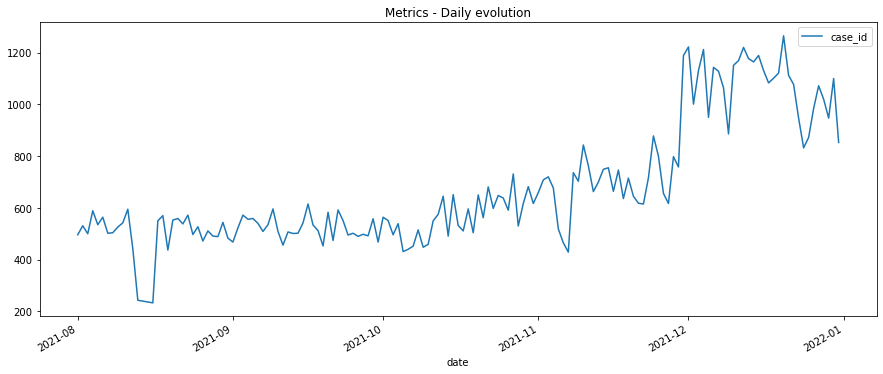

In [50]:
mask = (df['merchant_reference'].isin(mid)) & (df['month']>=7)

daily = df[mask].groupby(['date']).agg({
        'case_id': 'count',
        'usd_amount': np.sum,
        'app_pf_amt': np.sum, 
        'app_final_amt': np.sum})

daily['app_dlocal_amtr'] = daily['app_pf_amt']*(100) / daily['usd_amount']
daily['app_final_amtr'] = daily['app_final_amt']*(100) / daily['usd_amount']
daily['bank_reject_amtr'] = 100 - (daily['app_final_amt']*100 / daily['app_pf_amt'])

daily = daily[['case_id']].sort_values(['date'], ascending = (True))

daily.plot(kind="line",figsize=(15,6))
plt.title('Metrics - Daily evolution')
plt.show()

# --> Info Quality

### Codigo

In [51]:
var_list = [
    'user_domain', 'user_email', 'user_name', 'user_document', 'user_ip', 'user_cookie', 'user_phone', 'device_id', 'user_reference',
    'billing_state', 'billing_city', 'billing_postal_code', 'billing_address', 'billing_street', 'billing_number', 
    'description', 'sift_score', 'inhouse_score']

In [52]:
def check_info():    
    
    df_agr = df.groupby(['merchant_reference', 'merchant_name', 'country_code', 'month']).agg({

        'case_id': 'count',
        'user_domain': 'count',
        'user_email': 'count',
        'user_name': 'count',
        'user_document': 'count',
        'user_ip': 'count',
        'user_cookie': 'count',
        'user_phone': 'count',
        'device_id': 'count',
        'user_reference': 'count',
        'billing_state': 'count',
        'billing_city': 'count',
        'billing_postal_code': 'count',
        'billing_address': 'count',
        'billing_street': 'count',
        'billing_number': 'count', 
        'description': 'count',
        'sift_score': 'count',
        'inhouse_score': 'count'

    })

    for var in var_list:
        df_agr['pct_'+var] = df_agr[var]*100 / df_agr['case_id']
    
    return df_agr[['case_id', 'pct_user_domain', 'pct_user_email',
       'pct_user_name', 'pct_user_document', 'pct_user_ip', 'pct_user_cookie',
       'pct_user_phone', 'pct_device_id', 'pct_user_reference',
       'pct_billing_state', 'pct_billing_city', 'pct_billing_postal_code',
       'pct_billing_address', 'pct_billing_street', 'pct_billing_number',
       'pct_description', 'pct_sift_score', 'pct_inhouse_score']]

### Uso

In [53]:
check_info()

case_id  \
merchant_reference merchant_name         country_code month            
29641              Altercon Group s.r.o. AR           8         2392   
                                                      9         2869   
                                                      10        2868   
                                                      11        3282   
                                                      12        5046   
                                         BR           8         5344   
                                                      9         5637   
                                                      10        6331   
                                                      11        7592   
                                                      12       13320   
                                         CL           8         1577   
                                                      9         1839   
                                                      10        1724   
                                                      11        2791   
                                                      12        3225   
                                         CO           8         1274   
                                                      9         1371   
                                                      10        1495   
                                                      11        2038   
                                                      12        1933   
                                         ES           8            1   
                                         IN           8           29   
                                                      9           39   
                                                      10          41   
                                                      11          39   
                                                      12          41   
                                         MX           8         1646   
                                                      9         1769   
                                                      10        2446   
                                                      11        2351   
                                                      12        6126   
                                         PE           8         2234   
                                                      9         2084   
                                                      10        2517   
                                                      11        2949   
                                                      12        2647   
                                         PY           8           96   
                                                      9           81   
                                                      10          73   
                                                      11          98   
                                                      12          89   
                                         TR           8            1   
                                                      9            3   
                                                      12         893   
                                         US           8            1   
                                                      12           4   

                                                             pct_user_domain  \
merchant_reference merchant_name         country_code month                    
29641              Altercon Group s.r.o. AR           8               100.00   
                                                      9               100.00   
                                                      10              100.00   
                                                      11              100.00   
                                                      12              100.00   
                                         BR 

# Disparadores

### Codigo

In [54]:
def agrupar_disparador(mid, country, start_date, end_date, app_dlocal, app_final, variables_agrupacion, order_var, ascending_var, tipo_trx, bin_code, dff, flt1,flt1_value, flt2,flt2_value,flt3, flt3_value):
    
    df2 = dff.copy()
    
    df2 = df2[df2['merchant_reference'] == str(mid)]
            
    if country != 'ALL':
        df2 = df2[df2['country_code'] == str(country)]
    
    if app_dlocal != 'ALL':
        df2 = df2[df2['flag_app_pf'] == app_dlocal] 
        
    if app_final != 'ALL':      
        df2 = df2[df2['flag_app_final'] == app_final]

    if bin_code != 'ALL':      
        df2 = df2[df2['card_bin'] == bin_code]
        
    if start_date != 'date':
        df2 = df2[df2['date'] >= start_date]
        
    if end_date != 'date':
        df2 = df2[df2['date'] <= end_date]
        
    if flt1 != 'flt_1':
        df2= df2[df2[flt1].isin(flt1_value)]
    
    if flt2 != 'flt_2':
        df2= df2[df2[flt2].isin(flt2_value)]
        
    if flt3 != 'flt_3':
        df2= df2[df2[flt3] < flt3_value]
        
    #if filtro_cbk != 'ALL':      
        #df2 = df2[df2['cbk_flag'] == filtro_cbk]
        
    lista_agrupar = ['merchant_name']
    
    for var in variables_agrupacion:
        lista_agrupar.append(var)
        
    agr = df2.groupby(lista_agrupar).agg({
        
        'case_id':'count',
        'usd_amount': np.sum,
        
        'flag_app_pf': np.sum,
        'app_pf_amt': np.sum,
        
        'flag_app_final': np.sum,
        'app_final_amt':  np.sum,
        
        'cbk_flag': np.sum,
        'cbk_amt': np.sum,

        'cbk_flag_30_days': np.sum,        
        'cbk_amt_30_days': np.sum

    })
    
    agr['app_dlo'] = agr['app_pf_amt']*100 / agr['usd_amount']
    
    agr['bank_reject_amt'] = 100 - (agr['app_final_amt']*100 / agr['app_pf_amt'])
    
    agr['cbk_rate'] = agr['cbk_amt']*100 / agr['app_final_amt']
    
    agr['cbk_rate_qty'] = agr['cbk_flag']*100 / agr['flag_app_final']
    
    agr['cbk_rate_30d'] = agr['cbk_amt_30_days']*100 / agr['app_final_amt']
    
    agr['cbk_rate_qty_30d'] = agr['cbk_flag_30_days']*100 / agr['flag_app_final']
    
    agr['pct_total_cbk'] = agr['cbk_amt']*100 / agr['cbk_amt'].sum()
    
    agr['pct_total_final_amt'] = agr['app_final_amt']*100 / agr['app_final_amt'].sum()
    
    agr['pct_total_inc_amt'] = agr['usd_amount']*100 / agr['usd_amount'].sum()
    agr['pct_total_inc_qty'] = agr['case_id']*100 / agr['case_id'].sum()
    
    agr = agr.sort_values(order_var, ascending = ascending_var)
    
    agr['cumul_inc_amt'] = agr['pct_total_inc_amt'].cumsum()
    agr['cumul_cbk_amt'] = agr['pct_total_cbk'].cumsum()
    agr['cumul_final_amt'] = agr['pct_total_final_amt'].cumsum()
    
    agr['pp_final'] = (agr['pct_total_final_amt'].cumsum() * (agr['app_final_amt'].sum()*100 / agr['usd_amount'].sum()))/100
    
    if tipo_trx == 'RELEVANT':
        agr = agr[agr['flag_app_final'] > 300]
                
    
    return agr.sort_values(order_var, ascending = ascending_var)

In [55]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var)

# agrupar_disparador(29660, 'MX', 'ALL', 'ALL', ['user_domain'], ['cbk_amt'], [False], 'ALL', df).head()

In [56]:
mid = '29641'

# --> General

## bank / BIN

In [57]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, filtro_cbk, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['card_bin'], ['cbk_amt'], [False], 'ALL', 'ALL',df,  'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(30)


case_id  usd_amount  flag_app_pf  app_pf_amt  \
merchant_name         card_bin                                                 
Altercon Group s.r.o. 415231       2327  127,915.50         2306  126,614.26   
                      557910        732   37,478.04          721   36,879.80   
                      491566       1088   59,880.87         1073   58,740.72   
                      481516        701   34,271.12          686   33,124.20   
                      520416        578   33,049.36          567   32,426.05   
                      402766        567   30,569.41          552   29,388.04   
                      549138         79    3,711.26           79    3,711.26   
                      481515        133    7,205.07          132    7,179.95   
                      551238        203   10,710.02          201   10,613.67   
                      493173         45    2,717.55           42    2,469.24   
                      481514         48    2,561.29           48    2,561.29   
                      525678        752   39,012.19          744   38,504.31   
                      557907        327   17,796.96          325   17,696.21   
                      426807        151    8,901.83          148    8,781.31   
                      416916        923   51,861.77          913   51,373.18   
                      458909         65    4,326.90           62    4,240.49   
                      545631          3      219.45            3      219.45   
                      549949         44    2,428.63           33    1,745.74   
                      528843         31    2,152.26           30    2,068.27   
                      557920        148    7,678.67          148    7,678.67   
                      493172         31    1,837.98           28    1,238.01   
                      547046         56    3,956.75           24    1,314.31   
                      421003         73    4,248.47           73    4,248.47   
                      520694         18    1,099.97           18    1,099.97   
                      371774         25    1,308.05           25    1,308.05   
                      404313         29    1,846.77           29    1,846.77   
                      548234         19      991.23           19      991.23   
                      481283         34    1,957.09           34    1,957.09   
                      518899         14      875.16           14      875.16   
                      491871         22    1,292.74           21    1,257.30   

                                flag_app_final  app_final_amt  cbk_flag  \
merchant_name         card_bin                                            
Altercon Group s.r.o. 415231               206       8,408.93        24   
                      557910               107       4,722.94        18   
                      491566               189       8,570.68        15   
                      481516               163       7,381.83        14   
                      520416               129       6,197.17        12   
                      402766                65       2,871.09        13   
                      549138                40       1,888.85        10   
                      481515                53       2,704.99        11   
                      551238                36       1,715.23         9   
                      493173                15         962.14         7   
                      481514                36       1,793.02         9   
                      525678               140       6,152.96         9   
                      557907                57       2,762.01         4   
                      426807                52       2,463.71         5   
                      416916               113       5,248.52         6   
                      458909                12         648.28         5   
                      545631                 3         219.45         3   
                      549949                21

In [58]:

#bin con cbk mayor a 25% BR
dirty_bin_BR = ['410863', '535081, 525320', '606282', '523284','470598', '498442', '470598', '543882']
#special_bin = ['550209','516292','523421','553636','522688']
#clean_bin = ['230650','230744','511477','222763','533728']

#bin con cbk mayor a 20% MX

dirty_bin_MX = ['551238','549138','402766','493173','481514','458909','493172','547046','421003','404313','491871','430967','376703','481283','520694']
#special_bin = ['550209','516292','523421','553636','522688']
#clean_bin = ['230650','230744','511477','222763','533728']

In [59]:
df['bin_class'] = np.where(df['card_bin'].isin(dirty_bin_BR),'dirty class_BR',
                  np.where(df['card_bin'].isin(dirty_bin_MX),'dirty class_MX',
                  'other'))

In [ ]:
#df['bin_class'] = np.where(df['card_bin'].isin(dirty_bin),'dirty class',
#                  np.where(df['card_bin'].isin(special_bin),'special class',
 #                 np.where(df['card_bin'].isin(clean_bin),'clean class','other')))

In [ ]:
## filtro para br y mx los peores bin vs el resto

In [66]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, filtro_cbk, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'BR','date','2021-12-20', 'ALL', 'ALL', ['bin_class'], ['cbk_amt'], [False], 'ALL', 'ALL',df,  'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(30)


case_id   usd_amount  flag_app_pf  \
merchant_name         bin_class                                           
Altercon Group s.r.o. other             32018 1,261,849.54        30362   
                      dirty class_BR     2210    90,299.63         2126   

                                       app_pf_amt  flag_app_final  \
merchant_name         bin_class                                     
Altercon Group s.r.o. other          1,167,510.49            8174   
                      dirty class_BR    86,393.79             453   

                                      app_final_amt  cbk_flag   cbk_amt  \
merchant_name         bin_class                                           
Altercon Group s.r.o. other              285,765.24       811 34,325.87   
                      dirty class_BR      16,007.24       103  4,692.43   

                                      cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         bin_class                                           
Altercon Group s.r.o. other                        675        28,689.51   
                      dirty class_BR                89         4,227.41   

                                      app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         bin_class                                            
Altercon Group s.r.o. other             92.52            75.52     12.01   
                      dirty class_BR    95.67            81.47     29.31   

                                      cbk_rate_qty  cbk_rate_30d  \
merchant_name         bin_class                                    
Altercon Group s.r.o. other                   9.92         10.04   
                      dirty class_BR         22.74         26.41   

                                      cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         bin_class                                         
Altercon Group s.r.o. other                       8.26          87.97   
                      dirty class_BR             19.65          12.03   

                                      pct_total_final_amt  pct_total_inc_amt  \
merchant_name         bin_class                                                
Altercon Group s.r.o. other                         94.70              93.32   
                      dirty class_BR                 5.30               6.68   

                                      pct_total_inc_qty  cumul_inc_amt  \
merchant_name         bin_class                                          
Altercon Group s.r.o. other                       93.54          93.32   
                      dirty class_BR               6.46         100.00   

                                      cumul_cbk_amt  cumul_final_amt  pp_final  
merchant_name         bin_class                                                 
Altercon Group s.r.o. other                   87.97            94.70     21.13  
                      dirty class_BR         100.00           100.00     22.32

In [67]:
agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['bin_class'], ['cbk_amt'], [False], 'ALL', 'ALL',df,  'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(30)


case_id  usd_amount  flag_app_pf  \
merchant_name         bin_class                                          
Altercon Group s.r.o. other             11152  617,039.75        10876   
                      dirty class_MX     1288   71,902.09         1228   

                                      app_pf_amt  flag_app_final  \
merchant_name         bin_class                                    
Altercon Group s.r.o. other           596,837.78            2000   
                      dirty class_MX   66,961.95             280   

                                      app_final_amt  cbk_flag  cbk_amt  \
merchant_name         bin_class                                          
Altercon Group s.r.o. other               95,381.45       184 9,935.97   
                      dirty class_MX      13,887.27        75 4,527.72   

                                      cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         bin_class                                           
Altercon Group s.r.o. other                        137         7,701.49   
                      dirty class_MX                48         2,868.20   

                                      app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         bin_class                                            
Altercon Group s.r.o. other             96.73            84.02     10.42   
                      dirty class_MX    93.13            79.26     32.60   

                                      cbk_rate_qty  cbk_rate_30d  \
merchant_name         bin_class                                    
Altercon Group s.r.o. other                   9.20          8.07   
                      dirty class_MX         26.79         20.65   

                                      cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         bin_class                                         
Altercon Group s.r.o. other                       6.85          68.70   
                      dirty class_MX             17.14          31.30   

                                      pct_total_final_amt  pct_total_inc_amt  \
merchant_name         bin_class                                                
Altercon Group s.r.o. other                         87.29              89.56   
                      dirty class_MX                12.71              10.44   

                                      pct_total_inc_qty  cumul_inc_amt  \
merchant_name         bin_class                                          
Altercon Group s.r.o. other                       89.65          89.56   
                      dirty class_MX              10.35         100.00   

                                      cumul_cbk_amt  cumul_final_amt  pp_final  
merchant_name         bin_class                                                 
Altercon Group s.r.o. other                   68.70            87.29     13.84  
                      dirty class_MX         100.00           100.00     15.86

## country

In [68]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['country_code'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         country_code                                      
Altercon Group s.r.o. BR              34228 1,352,149.17        32488   
                      MX              12440   688,941.84        12104   
                      PE              11578   635,813.22        11175   
                      CO               7397   397,942.57         6995   
                      CL              10156   487,119.23         9879   
                      AR              14483   332,713.66        14324   
                      PY                395    15,134.91          364   
                      TR                571     9,017.97          561   
                      ES                  1       119.39            1   
                      IN                180     7,853.04          176   

                                     app_pf_amt  flag_app_final  \
merchant_name         country_code                                
Altercon Group s.r.o. BR           1,253,904.28            8627   
                      MX             663,799.73            2280   
                      PE             614,351.38            1779   
                      CO             372,457.98            1550   
                      CL             469,955.76            2091   
                      AR             328,332.73            3669   
                      PY              13,370.90             130   
                      TR               8,862.52             107   
                      ES                 119.39               0   
                      IN               7,584.55               0   

                                    app_final_amt  cbk_flag   cbk_amt  \
merchant_name         country_code                                      
Altercon Group s.r.o. BR               301,772.48       914 39,018.30   
                      MX               109,268.72       259 14,463.69   
                      PE                77,103.86       137  6,882.52   
                      CO                72,961.76       114  6,415.66   
                      CL                93,295.32        70  4,116.88   
                      AR                60,562.99        69  2,018.07   
                      PY                 4,441.28         2    150.99   
                      TR                 1,410.19         2     25.91   
                      ES                     0.00         0      0.00   
                      IN                     0.00         0      0.00   

                                    cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         country_code                                      
Altercon Group s.r.o. BR                         764        32,916.92   
                      MX                         185        10,569.69   
                      PE                          81         4,541.14   
                      CO                          72         4,398.66   
                      CL                          31         2,042.75   
                      AR                           8           158.57   
                      PY                           1            32.00   
                      TR                           2            25.91   
                      ES                           0             0.00   
                      IN                           0             0.00   

                                    app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         country_code                                       
Altercon Group s.r.o. BR              92.73            75.93     12.93   
                      MX              96.35            83.54     13.24   
                      PE              96.62            87.45      8.93   
                      CO              93.60            80.41      8.79   
                      CL              96.48            80.15      4.41   
                      AR              98.68            81.55      3.33   
        

In [ ]:
## BR y MX cbk rate >10%

## user mail domain

In [69]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['user_domain'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         user_domain                                         
Altercon Group s.r.o. gmail.com         64665 2,794,633.52        62342   
                      hotmail.com       16559   697,930.50        15951   
                      outlook.com        1796    78,233.95         1731   
                      yahoo.com.br        916    35,412.45          881   
                      icloud.com         1302    53,140.38         1258   
                      yahoo.com           611    27,303.68          598   
                      outlook.com.br       75     3,620.44           69   
                      uol.com.br          151     5,960.36          146   
                      bol.com.br          144     6,307.21          137   
                      hormail.com          53     2,027.72           53   

                                       app_pf_amt  flag_app_final  \
merchant_name         user_domain                                   
Altercon Group s.r.o. gmail.com      2,660,461.58           12356   
                      hotmail.com      663,104.03            4890   
                      outlook.com       73,829.32             407   
                      yahoo.com.br      33,633.98             360   
                      icloud.com        50,502.95             310   
                      yahoo.com         26,646.71             192   
                      outlook.com.br     3,372.45              30   
                      uol.com.br         5,610.95              86   
                      bol.com.br         5,908.01              59   
                      hormail.com        2,027.72              16   

                                      app_final_amt  cbk_flag   cbk_amt  \
merchant_name         user_domain                                         
Altercon Group s.r.o. gmail.com          441,595.31      1010 46,866.64   
                      hotmail.com        171,585.20       355 17,121.55   
                      outlook.com         15,094.67        28  1,497.95   
                      yahoo.com.br        12,831.44        31  1,260.66   
                      icloud.com          10,447.99        19    847.64   
                      yahoo.com            6,948.77        20    741.51   
                      outlook.com.br       1,295.28         8    586.43   
                      uol.com.br           3,356.22         6    303.41   
                      bol.com.br           2,132.32         5    221.74   
                      hormail.com            471.70         6    196.44   

                                      cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         user_domain                                         
Altercon Group s.r.o. gmail.com                    726        34,809.85   
                      hotmail.com                  271        13,173.30   
                      outlook.com                   15           753.68   
                      yahoo.com.br                  28         1,170.09   
                      icloud.com                    16           670.30   
                      yahoo.com                     16           620.32   
                      outlook.com.br                 8           586.43   
                      uol.com.br                     5           248.49   
                      bol.com.br                     3           137.61   
                      hormail.com                    3            88.15   

                                      app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         user_domain                                          
Altercon Group s.r.o. gmail.com         95.20            83.40     10.61   
                      hotmail.com       95.01            74.12      9.98   
                      outlook.com       94.37            79.55      9.92   
                      yahoo.com.br      94.98            61.85      9.82   
                      icloud.com        95.04     

## operation type

In [70]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['operation_type'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         operation_type                                      
Altercon Group s.r.o. WITH_CVV          62318 2,760,789.76        59774   
                      TOKEN             29104 1,165,595.08        28286   
                      WITHOUT_CVV           8       560.15            8   

                                       app_pf_amt  flag_app_final  \
merchant_name         operation_type                                
Altercon Group s.r.o. WITH_CVV       2,613,374.12           11736   
                      TOKEN          1,118,944.94            8497   
                      WITHOUT_CVV          560.15               0   

                                      app_final_amt  cbk_flag   cbk_amt  \
merchant_name         operation_type                                      
Altercon Group s.r.o. WITH_CVV           417,122.03       955 43,963.47   
                      TOKEN              303,694.57       612 29,128.55   
                      WITHOUT_CVV              0.00         0      0.00   

                                      cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         operation_type                                      
Altercon Group s.r.o. WITH_CVV                     725        34,046.86   
                      TOKEN                        419        20,638.78   
                      WITHOUT_CVV                    0             0.00   

                                      app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         operation_type                                       
Altercon Group s.r.o. WITH_CVV          94.66            84.04     10.54   
                      TOKEN             96.00            72.86      9.59   
                      WITHOUT_CVV      100.00           100.00       nan   

                                      cbk_rate_qty  cbk_rate_30d  \
merchant_name         operation_type                               
Altercon Group s.r.o. WITH_CVV                8.14          8.16   
                      TOKEN                   7.20          6.80   
                      WITHOUT_CVV              nan           nan   

                                      cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         operation_type                                    
Altercon Group s.r.o. WITH_CVV                    6.18          60.15   
                      TOKEN                       4.93          39.85   
                      WITHOUT_CVV                  nan           0.00   

                                      pct_total_final_amt  pct_total_inc_amt  \
merchant_name         operation_type                                           
Altercon Group s.r.o. WITH_CVV                      57.87              70.30   
                      TOKEN                         42.13              29.68   
                      WITHOUT_CVV                    0.00               0.01   

                                      pct_total_inc_qty  cumul_inc_amt  \
merchant_name         operation_type                                     
Altercon Group s.r.o. WITH_CVV                    68.16          70.30   
                      TOKEN                       31.83          99.99   
                      WITHOUT_CVV                  0.01         100.00   

                                      cumul_cbk_amt  cumul_final_amt  pp_final  
merchant_name         operation_type                                            
Altercon Group s.r.o. WITH_CVV                60.15            57.87     10.62  
                      TOKEN                  100.00           100.00     18.36  
                      WITHOUT_CVV            100.00           100.00     18.36

## billing_state / billing_city

In [71]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['billing_state'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

,,case_id,usd_amount,flag_app_pf,app_pf_amt,flag_app_final,app_final_amt,cbk_flag,cbk_amt,cbk_flag_30_days,cbk_amt_30_days,app_dlo,bank_reject_amt,cbk_rate,cbk_rate_qty,cbk_rate_30d,cbk_rate_qty_30d,pct_total_cbk,pct_total_final_amt,pct_total_inc_amt,pct_total_inc_qty,cumul_inc_amt,cumul_cbk_amt,cumul_final_amt,pp_final
merchant_name,billing_state,,,,,,,,,,,,,,,,,,,,,,,,
Altercon Group s.r.o.,NP,180,"7,853.04",176,"7,584.55",0,0.00,0,0.00,0,0.00,96.58,100.00,nan,nan,nan,nan,nan,nan,100.00,100.00,100.00,nan,nan,nan


## foreign card flag

In [72]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['flag_foreign_card'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         flag_foreign_card                                      
Altercon Group s.r.o. 0                    90895 3,901,701.87        87586   
                      1                      535    25,243.12          482   

                                          app_pf_amt  flag_app_final  \
merchant_name         flag_foreign_card                                
Altercon Group s.r.o. 0                 3,710,181.74           20187   
                      1                    22,697.47              46   

                                         app_final_amt  cbk_flag   cbk_amt  \
merchant_name         flag_foreign_card                                      
Altercon Group s.r.o. 0                     719,019.60      1564 72,957.04   
                      1                       1,797.00         3    134.98   

                                         cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         flag_foreign_card                                      
Altercon Group s.r.o. 0                              1143        54,653.64   
                      1                                 1            32.00   

                                         app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         flag_foreign_card                                       
Altercon Group s.r.o. 0                    95.09            80.62     10.15   
                      1                    89.92            92.08      7.51   

                                         cbk_rate_qty  cbk_rate_30d  \
merchant_name         flag_foreign_card                               
Altercon Group s.r.o. 0                          7.75          7.60   
                      1                          6.52          1.78   

                                         cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         flag_foreign_card                                    
Altercon Group s.r.o. 0                              5.66          99.82   
                      1                              2.17           0.18   

                                         pct_total_final_amt  \
merchant_name         flag_foreign_card                        
Altercon Group s.r.o. 0                                99.75   
                      1                                 0.25   

                                         pct_total_inc_amt  pct_total_inc_qty  \
merchant_name         flag_foreign_card                                         
Altercon Group s.r.o. 0                              99.36              99.41   
                      1                               0.64               0.59   

                                         cumul_inc_amt  cumul_cbk_amt  \
merchant_name         flag_foreign_card                                 
Altercon Group s.r.o. 0                          99.36          99.82   
                      1                         100.00         100.00   

                                         cumul_final_amt  pp_final  
merchant_name         flag_foreign_card                             
Altercon Group s.r.o. 0                            99.75     18.31  
                      1                           100.00     18.36

## card category

In [73]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['card_brand'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         card_brand                                      
Altercon Group s.r.o. VI            49350 2,178,497.41        48104   
                      MC            36161 1,488,470.07        34246   
                      EL             3171   131,467.50         3037   
                      AE             1029    50,829.56         1003   
                      HI              208     9,487.53          191   
                      CB               43       845.34           41   
                      CL                4        89.94            4   
                      CM              897    42,346.99          875   
                      CO                1        12.15            1   
                      DC                1        11.45            1   

                                   app_pf_amt  flag_app_final  app_final_amt  \
merchant_name         card_brand                                               
Altercon Group s.r.o. VI         2,113,591.81           10776     371,737.02   
                      MC         1,368,665.76            7938     285,990.67   
                      EL           125,593.43             812      29,754.12   
                      AE            49,221.23             361      18,894.99   
                      HI             8,568.81              27         824.25   
                      CB               770.90               9         114.51   
                      CL                89.94               0           0.00   
                      CM            41,466.68             277      12,439.22   
                      CO                12.15               0           0.00   
                      DC                11.45               0           0.00   

                                  cbk_flag   cbk_amt  cbk_flag_30_days  \
merchant_name         card_brand                                         
Altercon Group s.r.o. VI               758 36,826.81               539   
                      MC               700 30,590.32               525   
                      EL                75  3,752.36                56   
                      AE                26  1,631.22                18   
                      HI                 8    291.31                 6   
                      CB                 0      0.00                 0   
                      CL                 0      0.00                 0   
                      CM                 0      0.00                 0   
                      CO                 0      0.00                 0   
                      DC                 0      0.00                 0   

                                  cbk_amt_30_days  app_dlo  bank_reject_amt  \
merchant_name         card_brand                                              
Altercon Group s.r.o. VI                27,375.49    97.02            82.41   
                      MC                23,162.35    91.95            79.10   
                      EL                 2,835.56    95.53            76.31   
                      AE                 1,120.70    96.84            61.61   
                      HI                   191.54    90.32            90.38   
                      CB                     0.00    91.19            85.15   
                      CL                     0.00   100.00           100.00   
                      CM                     0.00    97.92            70.00   
                      CO                     0.00   100.00           100.00   
                      DC                     0.00   100.00           100.00   

                                  cbk_rate  cbk_rate_qty  cbk_rate_30d  \
merchant_name         card_brand                                         
Altercon Group s.r.o. VI              9.91          7.03          7.36   
                      MC             10.70          8.82          8.10   
                      EL             12.61          9.24          9.53   
            

In [ ]:
## para BR el cbk rate más alto es en HI 35%, las demás tarjetas parecido
## para MX el cbk rate más alto es para la que más procesa - Visa



In [74]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['card_category'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         card_category                                      
Altercon Group s.r.o. CLASSIC          28145 1,223,198.24        27494   
                      GOLD             18209   789,320.07        16578   
                      STANDARD         14849   687,941.37        14461   
                      PLATINUM          4739   188,664.88         4584   
                      ELO Mais           798    31,345.19          767   
                      MULTIPLE          1456    61,519.31         1373   
                      WORLD               94     4,594.28           94   
                      GOLD/PLATINUM      662    36,650.32          647   
                      BLACK             1037    43,209.71         1022   
                      ELECTRON           578    29,679.71          567   

                                      app_pf_amt  flag_app_final  \
merchant_name         card_category                                
Altercon Group s.r.o. CLASSIC       1,187,503.38            5497   
                      GOLD            684,156.38            4282   
                      STANDARD        667,040.76            3048   
                      PLATINUM        182,547.68            2072   
                      ELO Mais         30,063.25             320   
                      MULTIPLE         57,688.01             281   
                      WORLD             4,594.28              51   
                      GOLD/PLATINUM    35,468.95             117   
                      BLACK            42,733.50             532   
                      ELECTRON         28,789.52             107   

                                     app_final_amt  cbk_flag   cbk_amt  \
merchant_name         card_category                                      
Altercon Group s.r.o. CLASSIC           178,543.30       350 18,104.38   
                      GOLD              147,182.93       401 15,999.62   
                      STANDARD          118,625.01       271 13,467.19   
                      PLATINUM           75,545.67       171  7,793.23   
                      ELO Mais           11,563.49        36  1,770.08   
                      MULTIPLE           10,569.69        29  1,312.51   
                      WORLD               2,630.10        12    755.40   
                      GOLD/PLATINUM       5,791.93        15    746.63   
                      BLACK              20,147.32        18    697.03   
                      ELECTRON            4,185.51        11    661.97   

                                     cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         card_category                                      
Altercon Group s.r.o. CLASSIC                     238        12,989.66   
                      GOLD                        299        12,458.20   
                      STANDARD                    186         9,650.17   
                      PLATINUM                    131         6,126.07   
                      ELO Mais                     26         1,292.58   
                      MULTIPLE                     24         1,132.74   
                      WORLD                         8           514.10   
                      GOLD/PLATINUM                14           711.97   
                      BLACK                        13           501.24   
                      ELECTRON                     11           661.97   

                                     app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         card_category                                       
Altercon Group s.r.o. CLASSIC          97.08            84.96     10.14   
                      GOLD             86.68            78.49     10.87   
                      STANDARD         96.96            82.22     11.35   
                      PLATINUM         96.76            58.62     10.32   
                      ELO Mais         95.91            61.54     15.31   
                      MULTIP

In [ ]:
##Para BR Elo Mais y Classic mayor cbk rate(15%), seguid por standard y gold (14%)
##Para MX World 28%, gold 22%, centurion 20%



## card type

In [75]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['card_type'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  flag_app_pf  \
merchant_name         card_type                                        
Altercon Group s.r.o. CREDIT         49775 2,010,688.24        47374   
                      DEBIT          41645 1,915,592.49        40684   
                      CHARGE_CARD        7       566.80            7   

                                    app_pf_amt  flag_app_final  app_final_amt  \
merchant_name         card_type                                                 
Altercon Group s.r.o. CREDIT      1,871,270.19           14534     523,255.59   
                      DEBIT       1,860,944.76            5698     197,476.68   
                      CHARGE_CARD       566.80               1          84.33   

                                   cbk_flag   cbk_amt  cbk_flag_30_days  \
merchant_name         card_type                                           
Altercon Group s.r.o. CREDIT           1255 57,195.86               925   
                      DEBIT             312 15,896.16               219   
                      CHARGE_CARD         0      0.00                 0   

                                   cbk_amt_30_days  app_dlo  bank_reject_amt  \
merchant_name         card_type                                                
Altercon Group s.r.o. CREDIT             42,571.16    93.07            72.04   
                      DEBIT              12,114.48    97.15            89.39   
                      CHARGE_CARD             0.00   100.00            85.12   

                                   cbk_rate  cbk_rate_qty  cbk_rate_30d  \
merchant_name         card_type                                           
Altercon Group s.r.o. CREDIT          10.93          8.63          8.14   
                      DEBIT            8.05          5.48          6.13   
                      CHARGE_CARD      0.00          0.00          0.00   

                                   cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         card_type                                      
Altercon Group s.r.o. CREDIT                   6.36          78.25   
                      DEBIT                    3.84          21.75   
                      CHARGE_CARD              0.00           0.00   

                                   pct_total_final_amt  pct_total_inc_amt  \
merchant_name         card_type                                             
Altercon Group s.r.o. CREDIT                     72.59              51.20   
                      DEBIT                      27.40              48.78   
                      CHARGE_CARD                 0.01               0.01   

                                   pct_total_inc_qty  cumul_inc_amt  \
merchant_name         card_type                                       
Altercon Group s.r.o. CREDIT                   54.44          51.20   
                      DEBIT                    45.55          99.99   
                      CHARGE_CARD               0.01         100.00   

                                   cumul_cbk_amt  cumul_final_amt  pp_final  
merchant_name         card_type                                              
Altercon Group s.r.o. CREDIT               78.25            72.59     13.33  
                      DEBIT               100.00            99.99     18.35  
                      CHARGE_CARD         100.00           100.00     18.36

## approval type

In [76]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['rule_type'], ['cbk_amt'], [False], 'ALL','ALL', df, 'online_verdict',['ACCEPT'],'flt_2','flt_2','flt_3','flt_3').head(10)

case_id  usd_amount  flag_app_pf  \
merchant_name         rule_type                                            
Altercon Group s.r.o. Default              9651  522,052.24         9651   
                      Positive history     1900  108,125.86         1900   
                      Positive others       553   33,621.63          553   

                                        app_pf_amt  flag_app_final  \
merchant_name         rule_type                                      
Altercon Group s.r.o. Default           522,052.24            1635   
                      Positive history  108,125.86             589   
                      Positive others    33,621.63              56   

                                        app_final_amt  cbk_flag   cbk_amt  \
merchant_name         rule_type                                             
Altercon Group s.r.o. Default               77,847.60       207 10,920.41   
                      Positive history      28,691.88        47  3,233.38   
                      Positive others        2,729.24         5    309.90   

                                        cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         rule_type                                             
Altercon Group s.r.o. Default                        150         8,174.87   
                      Positive history                30         2,084.92   
                      Positive others                  5           309.90   

                                        app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         rule_type                                              
Altercon Group s.r.o. Default            100.00            85.09     14.03   
                      Positive history   100.00            73.46     11.27   
                      Positive others    100.00            91.88     11.35   

                                        cbk_rate_qty  cbk_rate_30d  \
merchant_name         rule_type                                      
Altercon Group s.r.o. Default                  12.66         10.50   
                      Positive history          7.98          7.27   
                      Positive others           8.93         11.35   

                                        cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         rule_type                                           
Altercon Group s.r.o. Default                       9.17          75.50   
                      Positive history              5.09          22.36   
                      Positive others               8.93           2.14   

                                        pct_total_final_amt  \
merchant_name         rule_type                               
Altercon Group s.r.o. Default                         71.24   
                      Positive history                26.26   
                      Positive others                  2.50   

                                        pct_total_inc_amt  pct_total_inc_qty  \
merchant_name         rule_type                                                
Altercon Group s.r.o. Default                       78.65              79.73   
                      Positive history              16.29              15.70   
                      Positive others                5.07               4.57   

                                        cumul_inc_amt  cumul_cbk_amt  \
merchant_name         rule_type                                        
Altercon Group s.r.o. Default                   78.65          75.50   
                      Positive history          94.93          97.86   
                      Positive others          100.00         100.00   

                                        cumul_final_amt  pp_final  
merchant_name         rule_type                                    
Altercon Group s.r.o. Default                     71.24     11.73  
                      Positive history            97.50     16.05  
                      Positive others            100.00     16.46

In [ ]:
##En Br y MX tiene cbk rate más alto para positive users que por default

In [77]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['positive_user'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id   usd_amount  \
merchant_name         positive_user                                     
Altercon Group s.r.o. No Positive                  58198 2,600,418.36   
                      Positive History - Mature    18961   765,467.11   
                      Positive History - Recent     7042   273,102.99   
                      Positive Others               7229   287,956.53   

                                                 flag_app_pf   app_pf_amt  \
merchant_name         positive_user                                         
Altercon Group s.r.o. No Positive                      55244 2,429,273.98   
                      Positive History - Mature        18864   760,866.69   
                      Positive History - Recent         6788   257,689.39   
                      Positive Others                   7172   285,049.15   

                                                 flag_app_final  \
merchant_name         positive_user                               
Altercon Group s.r.o. No Positive                         11878   
                      Positive History - Mature            5843   
                      Positive History - Recent            1666   
                      Positive Others                       846   

                                                 app_final_amt  cbk_flag  \
merchant_name         positive_user                                        
Altercon Group s.r.o. No Positive                   433,633.45      1103   
                      Positive History - Mature     195,999.00       271   
                      Positive History - Recent      64,568.45       144   
                      Positive Others                26,615.70        49   

                                                  cbk_amt  cbk_flag_30_days  \
merchant_name         positive_user                                           
Altercon Group s.r.o. No Positive               51,165.48               818   
                      Positive History - Mature 12,755.17               186   
                      Positive History - Recent  6,661.79               103   
                      Positive Others            2,509.58                37   

                                                 cbk_amt_30_days  app_dlo  \
merchant_name         positive_user                                         
Altercon Group s.r.o. No Positive                      38,821.33    93.42   
                      Positive History - Mature         9,288.76    99.40   
                      Positive History - Recent         4,716.40    94.36   
                      Positive Others                   1,859.15    98.99   

                                                 bank_reject_amt  cbk_rate  \
merchant_name         positive_user                                          
Altercon Group s.r.o. No Positive                          82.15     11.80   
                      Positive History - Mature            74.24      6.51   
                      Positive History - Recent            74.94     10.32   
                      Positive Others                      90.66      9.43   

                                                 cbk_rate_qty  cbk_rate_30d  \
merchant_name         positive_user                                           
Altercon Group s.r.o. No Positive                        9.29          8.95   
                      Positive History - Mature          4.64          4.74   
                      Positive History - Recent          8.64          7.30   
                      Positive Others                    5.79          6.99   

                                                 cbk_rate_qty_30d  \
merchant_name         positive_user                                 
Altercon Group s.r.o. No Positive                            6.89   
                      Positive History - Mature              3.18   
                      Positive History - Recent              6.18   
                      Positive Others                       

## description

In [78]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['description'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  \
merchant_name         description                                                   
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...    36104   
                      for smartphones & tablets - 1 month Premium Sub...    33708   
                      for smartphones & tablets - 3 months Premium Su...    15709   
                      mAssistance - Help with installation on device         2106   
                      for smartphones & tablets - 1 month Basic Subsc...     2575   
                      for smartphones & tablets Family Kit - 12 month...       29   
                      Phone Support - 24/7 Premium Technical Assistance       749   
                      for smartphones & tablets - 3 months Basic Subs...      183   
                      for smartphones & tablets - 6 months Premium Su...      248   
                      for smartphones & tablets - 12 months Basic Sub...        1   

                                                                           usd_amount  \
merchant_name         description                                                       
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S... 2,066,567.99   
                      for smartphones & tablets - 1 month Premium Sub... 1,036,313.68   
                      for smartphones & tablets - 3 months Premium Su...   702,725.24   
                      mAssistance - Help with installation on device        53,333.16   
                      for smartphones & tablets - 1 month Basic Subsc...    34,004.69   
                      for smartphones & tablets Family Kit - 12 month...     5,188.30   
                      Phone Support - 24/7 Premium Technical Assistance      5,225.31   
                      for smartphones & tablets - 3 months Basic Subs...     5,163.71   
                      for smartphones & tablets - 6 months Premium Su...    15,908.84   
                      for smartphones & tablets - 12 months Basic Sub...        67.92   

                                                                          flag_app_pf  \
merchant_name         description                                                       
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...        34410   
                      for smartphones & tablets - 1 month Premium Sub...        32788   
                      for smartphones & tablets - 3 months Premium Su...        15067   
                      mAssistance - Help with installation on device             2051   
                      for smartphones & tablets - 1 month Basic Subsc...         2562   
                      for smartphones & tablets Family Kit - 12 month...           24   
                      Phone Support - 24/7 Premium Technical Assistance           728   
                      for smartphones & tablets - 3 months Basic Subs...          171   
                      for smartphones & tablets - 6 months Premium Su...          248   
                      for smartphones & tablets - 12 months Basic Sub...            1   

                                                                           app_pf_amt  \
merchant_name         description                                                       
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S... 1,947,096.24   
                      for smartphones & tablets - 1 month Premium Sub... 1,001,924.28   
                      for smartphones & tablets - 3 months Premium Su...   665,674.95   
                      mAssistance - Help with installation on device        51,861.68   
                      for smartphones & tablets - 1 month Basic Subsc...    33,809.29   
                      for smartphones & tablets Family Kit - 12 month...     4,227.51   
                      Phone Support - 24/7 Premium Technical Assistance      5,073.58   
                      for smartphones & tablets - 3 months Basic Subs...     4,788.77   
                      for

In [ ]:
## en BR  cbk rate más alto para productos anuales
#for smartphones & tablets Family Kit - 12 months Subscript (22%) 
##for smartphones & tablets - 12 months Premium Subscription (18%)

## seguido por 
##mAssistance - Help with installation on device (14)
## Phone Support - 24/7 Premium Technical Assistance (13%)

### en MX
##for smartphones & tablets - 12 months Premium Subscription (15%)
## for smartphones & tablets - 1 month Premium Subscription (14%)
## mAssistance - Help with installation on device (13.31%)



In [79]:
#filtro solo BR

agrupar_disparador(mid, 'BR','date','2021-12-20', 'ALL', 'ALL', ['description'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  \
merchant_name         description                                                   
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...    16163   
                      for smartphones & tablets - 3 months Premium Su...     6798   
                      for smartphones & tablets - 1 month Premium Sub...     9457   
                      mAssistance - Help with installation on device          559   
                      for smartphones & tablets Family Kit - 12 month...       18   
                      Phone Support - 24/7 Premium Technical Assistance       239   
                      for smartphones & tablets - 1 month Basic Subsc...      773   
                      for smartphones & tablets - 6 months Premium Su...      134   
                      for smartphones & tablets - 3 months Basic Subs...       75   
                      for smartphones & tablets Family Kit - 6 months...       11   

                                                                          usd_amount  \
merchant_name         description                                                      
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...  786,536.61   
                      for smartphones & tablets - 3 months Premium Su...  270,506.82   
                      for smartphones & tablets - 1 month Premium Sub...  256,503.87   
                      mAssistance - Help with installation on device       11,693.23   
                      for smartphones & tablets Family Kit - 12 month...    3,043.44   
                      Phone Support - 24/7 Premium Technical Assistance     1,605.71   
                      for smartphones & tablets - 1 month Basic Subsc...   10,802.52   
                      for smartphones & tablets - 6 months Premium Su...    8,025.61   
                      for smartphones & tablets - 3 months Basic Subs...    2,054.04   
                      for smartphones & tablets Family Kit - 6 months...    1,348.23   

                                                                          flag_app_pf  \
merchant_name         description                                                       
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...        15089   
                      for smartphones & tablets - 3 months Premium Su...         6499   
                      for smartphones & tablets - 1 month Premium Sub...         9125   
                      mAssistance - Help with installation on device              543   
                      for smartphones & tablets Family Kit - 12 month...           17   
                      Phone Support - 24/7 Premium Technical Assistance           235   
                      for smartphones & tablets - 1 month Basic Subsc...          763   
                      for smartphones & tablets - 6 months Premium Su...          134   
                      for smartphones & tablets - 3 months Basic Subs...           71   
                      for smartphones & tablets Family Kit - 6 months...           11   

                                                                          app_pf_amt  \
merchant_name         description                                                      
Altercon Group s.r.o. for smartphones & tablets - 12 months Premium S...  717,893.51   
                      for smartphones & tablets - 3 months Premium Su...  253,302.71   
                      for smartphones & tablets - 1 month Premium Sub...  244,889.38   
                      mAssistance - Help with installation on device       11,330.03   
                      for smartphones & tablets Family Kit - 12 month...    2,892.61   
                      Phone Support - 24/7 Premium Technical Assistance     1,578.42   
                      for smartphones & tablets - 1 month Basic Subsc...   10,664.79   
                      for smartphones & tablets - 6 months Premium Su...    8,025.61   
                      for smartphones & tablets

# --> Velocities

## card age

In [80]:
agrupar_disparador(mid, 'BR','date','2021-12-20', 'ALL', 'ALL', ['card_age_bin'], ['card_age_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id  usd_amount  flag_app_pf  \
merchant_name         card_age_bin                                     
Altercon Group s.r.o. 0               15281  612,549.37        14498   
                      7                3253  122,079.37         3032   
                      15                360   13,536.92          328   
                      30               1391   49,542.94         1303   
                      90               4033  149,770.59         3775   
                      180              3812  150,015.62         3682   
                      360              4275  159,404.47         4102   
                      999999           1823   95,249.89         1768   

                                    app_pf_amt  flag_app_final  app_final_amt  \
merchant_name         card_age_bin                                              
Altercon Group s.r.o. 0             565,164.98            3900     139,977.92   
                      7             109,508.81             363      10,943.17   
                      15             11,982.06              68       2,017.58   
                      30             45,160.46             438      14,858.55   
                      90            136,566.11             995      36,351.22   
                      180           143,373.62             983      36,984.92   
                      360           150,411.95            1390      46,287.89   
                      999999         91,736.29             490      14,351.23   

                                    cbk_flag   cbk_amt  cbk_flag_30_days  \
merchant_name         card_age_bin                                         
Altercon Group s.r.o. 0                  490 22,052.67               420   
                      7                   56  2,013.77                51   
                      15                   5    219.87                 3   
                      30                  60  2,114.26                48   
                      90                 101  3,922.12                81   
                      180                 82  3,585.90                63   
                      360                 93  3,709.25                76   
                      999999              27  1,400.46                22   

                                    cbk_amt_30_days  app_dlo  bank_reject_amt  \
merchant_name         card_age_bin                                              
Altercon Group s.r.o. 0                   19,050.96    92.26            75.23   
                      7                    1,842.68    89.70            90.01   
                      15                     149.95    88.51            83.16   
                      30                   1,703.12    91.15            67.10   
                      90                   3,232.16    91.18            73.38   
                      180                  2,599.66    95.57            74.20   
                      360                  3,093.85    94.36            69.23   
                      999999               1,244.54    96.31            84.36   

                                    cbk_rate  cbk_rate_qty  cbk_rate_30d  \
merchant_name         card_age_bin                                         
Altercon Group s.r.o. 0                15.75         12.56         13.61   
                      7                18.40         15.43         16.84   
                      15               10.90          7.35          7.43   
                      30               14.23         13.70         11.46   
                      90               10.79         10.15          8.89   
                      180               9.70          8.34          7.03   
                      360               8.01          6.69          6.68   
                      999999            9.76          5.51          8.67   

                                    cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         card_age_bin                                    
Altercon Group s.r.o. 0      

In [ ]:
## para MX el cbk rate más alto es con card age 15
## para BR el cbk rate más alto es con card age 7



## email age

In [81]:
agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['email_age_bin'], ['email_age_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id  usd_amount  flag_app_pf  \
merchant_name         email_age_bin                                     
Altercon Group s.r.o. 0                 5103  276,602.23         5032   
                      7                 1853  104,956.58         1741   
                      15                 152    8,335.11          146   
                      30                 707   37,582.58          692   
                      90                1665   86,812.29         1593   
                      180               1029   59,747.92         1018   
                      360                764   37,291.74          758   
                      999999            1167   77,613.39         1124   

                                     app_pf_amt  flag_app_final  \
merchant_name         email_age_bin                               
Altercon Group s.r.o. 0              270,759.39             819   
                      7               95,726.51             167   
                      15               7,984.47              17   
                      30              36,670.87             184   
                      90              82,342.93             337   
                      180             58,883.21             234   
                      360             36,998.81             192   
                      999999          74,433.54             330   

                                     app_final_amt  cbk_flag  cbk_amt  \
merchant_name         email_age_bin                                     
Altercon Group s.r.o. 0                  35,815.09        65 3,140.09   
                      7                   7,181.29        17   904.40   
                      15                    761.00         2   188.98   
                      30                 10,115.62        49 2,632.75   
                      90                 18,411.24        61 3,325.05   
                      180                12,734.07        21 1,344.37   
                      360                 8,929.79        21 1,289.68   
                      999999             15,320.62        23 1,638.37   

                                     cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         email_age_bin                                      
Altercon Group s.r.o. 0                            43         2,189.97   
                      7                            12           725.25   
                      15                            1            48.99   
                      30                           36         1,954.95   
                      90                           49         2,755.82   
                      180                          11           622.27   
                      360                          15           927.33   
                      999999                       18         1,345.11   

                                     app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         email_age_bin                                       
Altercon Group s.r.o. 0                97.89            86.77      8.77   
                      7                91.21            92.50     12.59   
                      15               95.79            90.47     24.83   
                      30               97.57            72.42     26.03   
                      90               94.85            77.64     18.06   
                      180              98.55            78.37     10.56   
                      360              99.21            75.86     14.44   
                      999999           95.90            79.42     10.69   

                                     cbk_rate_qty  cbk_rate_30d  \
merchant_name         email_age_bin                               
Altercon Group s.r.o. 0                      7.94          6.11   
                      7                     10.18         10.10   
                      15                    11.76          6.44   
                      30                    26.63         19.33   
          

In [ ]:
## para BR mayor cbk rate en email 15 días

## para BR mayor cbk rate en email  30 días seguido por 15

## same card 30d

In [82]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_card_30d_bin'], ['same_card_30d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_card_30d_bin                                      
Altercon Group s.r.o. 0                     2636   116,906.50         2526   
                      1                    22588 1,103,216.75        21441   
                      5                    44930 1,820,665.28        43850   
                      10                   13488   540,374.28        13094   
                      15                    3805   158,376.61         3683   
                      20                    1617    70,683.44         1534   
                      30                    1323    61,654.77         1185   
                      60                     822    42,163.36          620   
                      90                     130     7,729.78           82   
                      120                     72     4,484.75           36   
                      150                      5       250.56            4   
                      180                      3        83.06            3   
                      210                      3       137.77            3   
                      240                      1        25.10            0   
                      300                      7       192.98            7   

                                          app_pf_amt  flag_app_final  \
merchant_name         same_card_30d_bin                                
Altercon Group s.r.o. 0                   110,002.83             535   
                      1                 1,035,263.96            8356   
                      5                 1,761,155.32            9756   
                      10                  518,467.06            1169   
                      15                  151,337.01             224   
                      20                   65,943.89              78   
                      30                   53,413.44              57   
                      60                   30,267.71              51   
                      90                    4,448.44               7   
                      120                   1,981.79               0   
                      150                     183.95               0   
                      180                      83.06               0   
                      210                     137.77               0   
                      240                       0.00               0   
                      300                     192.98               0   

                                         app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_card_30d_bin                                      
Altercon Group s.r.o. 0                      19,654.81        45  1,821.80   
                      1                     332,833.95       723 37,370.07   
                      5                     317,537.45       706 30,220.02   
                      10                     36,072.63        79  3,106.18   
                      15                      6,838.96         9    339.04   
                      20                      3,011.19         4    195.92   
                      30                      1,976.37         1     38.99   
                      60                      2,590.02         0      0.00   
                      90                        301.22         0      0.00   
                      120                         0.00         0      0.00   
                      150                         0.00         0      0.00   
                      180                         0.00         0      0.00   
                      210                         0.00         0      0.00   
                      240                         0.00         0      0.00   
                      300                         0.00         0      0.00   

                                         cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_card_30d_bin                                      
Alterc

## same card 7d

In [83]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_card_7d_bin'], ['same_card_7d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_card_7d_bin                                      
Altercon Group s.r.o. 0                    2636   116,906.50         2526   
                      1                   36559 1,644,317.90        35111   
                      2                   15082   652,201.92        14687   
                      3                   14415   574,353.63        14048   
                      4                    6440   229,801.97         6300   
                      5                    3376   151,169.89         3275   
                      10                   8187   338,678.29         7914   
                      15                   2449   107,129.50         2334   
                      20                   1026    45,133.40          944   
                      30                    771    37,815.93          673   
                      60                    383    22,014.34          220   
                      90                     63     4,707.83           24   
                      120                    42     2,647.28           12   
                      150                     1        66.61            0   

                                         app_pf_amt  flag_app_final  \
merchant_name         same_card_7d_bin                                
Altercon Group s.r.o. 0                  110,002.83             535   
                      1                1,560,491.93           14421   
                      2                  628,914.33            2773   
                      3                  553,829.60            1193   
                      4                  222,279.83             576   
                      5                  145,451.08             256   
                      10                 323,721.08             361   
                      15                 100,743.49              73   
                      20                  41,189.45              25   
                      30                  32,162.86              17   
                      60                  11,688.25               3   
                      90                   1,843.11               0   
                      120                    561.37               0   
                      150                      0.00               0   

                                        app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_card_7d_bin                                      
Altercon Group s.r.o. 0                     19,654.81        45  1,821.80   
                      1                    533,548.41      1101 54,047.36   
                      2                     88,931.05       242 10,195.81   
                      3                     39,825.78        95  4,021.40   
                      4                     16,022.19        47  1,552.24   
                      5                      7,898.32        14    541.00   
                      10                    10,932.89        21    866.82   
                      15                     2,435.92         1      6.60   
                      20                       969.56         0      0.00   
                      30                       527.88         1     38.99   
                      60                        69.79         0      0.00   
                      90                         0.00         0      0.00   
                      120                        0.00         0      0.00   
                      150                        0.00         0      0.00   

                                        cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_card_7d_bin                                      
Altercon Group s.r.o. 0                               38         1,475.56   
                      1                              811        40,827.24   
                      2                              173         7,598.17   
                      3                             

## same card 1d

In [84]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_card_1d_bin'], ['same_card_1d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_card_1d_bin                                      
Altercon Group s.r.o. 0                    2636   116,906.50         2526   
                      1                   48974 2,161,808.07        47150   
                      2                   11912   522,125.17        11623   
                      3                    8950   348,920.51         8753   
                      4                    5753   198,608.22         5613   
                      5                    2827   129,475.55         2737   
                      10                   6849   284,206.61         6602   
                      15                   1965    85,325.62         1865   
                      20                    728    32,518.92          659   
                      30                    505    26,412.80          422   
                      60                    262    15,644.88          118   
                      90                     46     3,439.54            0   
                      120                    23     1,552.60            0   

                                         app_pf_amt  flag_app_final  \
merchant_name         same_card_1d_bin                                
Altercon Group s.r.o. 0                  110,002.83             535   
                      1                2,055,477.31           16391   
                      2                  504,936.00            1966   
                      3                  338,760.46             501   
                      4                  191,172.07             432   
                      5                  124,298.02             162   
                      10                 271,394.58             206   
                      15                  80,149.20              25   
                      20                  29,067.70              11   
                      30                  21,353.52               4   
                      60                   6,267.52               0   
                      90                       0.00               0   
                      120                      0.00               0   

                                        app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_card_1d_bin                                      
Altercon Group s.r.o. 0                     19,654.81        45  1,821.80   
                      1                    603,484.68      1235 60,636.44   
                      2                     58,721.65       189  7,076.21   
                      3                     16,737.60        41  1,771.40   
                      4                     11,419.53        35  1,060.64   
                      5                      4,519.28        10    371.11   
                      10                     5,248.52        10    308.83   
                      15                       605.51         1      6.60   
                      20                       315.06         0      0.00   
                      30                       109.96         1     38.99   
                      60                         0.00         0      0.00   
                      90                         0.00         0      0.00   
                      120                        0.00         0      0.00   

                                        cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_card_1d_bin                                      
Altercon Group s.r.o. 0                               38         1,475.56   
                      1                              903        45,504.24   
                      2                              132         5,248.39   
                      3                               28         1,053.64   
                      4                               27           839.55   
                      5                                9           363.71   
                      10                      

In [ ]:
## same card BR- 2 es elq ue tiene más cbk
## same card MX- 3 es elq ue tiene más cbk (25%), pero cbk rate 30 d no



## same email 30d

In [85]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_email_30d_bin'], ['same_email_30d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_email_30d_bin                                      
Altercon Group s.r.o. 0                      2632   116,775.96         2522   
                      1                     23957 1,178,810.05        22977   
                      5                     46490 1,867,398.90        45391   
                      10                    12473   499,305.11        11959   
                      15                     2983   128,861.19         2795   
                      20                     1251    54,939.32         1127   
                      30                      975    46,507.11          849   
                      60                      580    28,817.34          383   
                      90                       76     4,380.21           52   
                      120                      12     1,115.91           12   
                      150                       1        33.89            1   

                                           app_pf_amt  flag_app_final  \
merchant_name         same_email_30d_bin                                
Altercon Group s.r.o. 0                    109,872.29             534   
                      1                  1,115,142.25            9025   
                      5                  1,803,912.46            9403   
                      10                   473,700.22             988   
                      15                   119,831.64             161   
                      20                    48,566.53              53   
                      30                    40,347.17              37   
                      60                    17,559.97              24   
                      90                     2,796.88               7   
                      120                    1,115.91               0   
                      150                       33.89               1   

                                          app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_email_30d_bin                                      
Altercon Group s.r.o. 0                       19,621.18        45  1,821.80   
                      1                      361,145.25       747 38,600.42   
                      5                      300,861.24       694 29,396.92   
                      10                      29,871.20        64  2,628.81   
                      15                       4,873.30        10    407.09   
                      20                       1,888.60         3     59.42   
                      30                       1,436.10         3    107.56   
                      60                         791.75         1     70.00   
                      90                         294.09         0      0.00   
                      120                          0.00         0      0.00   
                      150                         33.89         0      0.00   

                                          cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_email_30d_bin                                      
Altercon Group s.r.o. 0                                 38         1,475.56   
                      1                                585        31,132.02   
                      5                                463        19,658.60   
                      10                                47         2,016.33   
                      15                                 6           190.58   
                      20                                 1            34.99   
                      30                                 3           107.56   
                      60                                 1            70.00   
                      90                                 0             0.00   
                      120                                0             0.00   
                      150                                0             0.00   

        

## same email 7d

In [86]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_email_7d_bin'], ['same_email_7d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_email_7d_bin                                      
Altercon Group s.r.o. 0                     2632   116,775.96         2522   
                      1                    37144 1,670,217.46        35920   
                      2                    14732   638,456.12        14366   
                      3                    14747   584,511.12        14369   
                      4                     6208   221,179.74         6061   
                      5                     3290   148,638.12         3169   
                      10                    7994   332,462.25         7579   
                      15                    2447   106,005.78         2274   
                      20                     990    44,391.57          875   
                      30                     754    37,054.53          641   
                      60                     444    23,661.36          261   
                      90                      47     3,557.09           30   
                      120                      1        33.89            1   

                                          app_pf_amt  flag_app_final  \
merchant_name         same_email_7d_bin                                
Altercon Group s.r.o. 0                   109,872.29             534   
                      1                 1,593,291.38           14746   
                      2                   615,597.31            2354   
                      3                   563,169.38            1183   
                      4                   213,264.01             566   
                      5                   141,837.17             306   
                      10                  312,723.31             402   
                      15                   97,535.59              83   
                      20                   38,617.27              34   
                      30                   31,820.38              18   
                      60                   12,976.58               5   
                      90                    2,140.65               1   
                      120                      33.89               1   

                                         app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_email_7d_bin                                      
Altercon Group s.r.o. 0                      19,621.18        45  1,821.80   
                      1                     546,370.99      1115 54,764.75   
                      2                      73,876.08       218  8,976.27   
                      3                      38,620.93        98  4,198.89   
                      4                      15,907.97        41  1,441.12   
                      5                       9,626.61        17    628.55   
                      10                     12,086.74        27  1,083.62   
                      15                      2,667.10         3     83.46   
                      20                      1,306.74         2     54.57   
                      30                        566.89         1     38.99   
                      60                         96.56         0      0.00   
                      90                         34.92         0      0.00   
                      120                        33.89         0      0.00   

                                         cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_email_7d_bin                                      
Altercon Group s.r.o. 0                                38         1,475.56   
                      1                               818        41,267.49   
                      2                               147         6,205.22   
                      3                                71         3,051.09   
                      4                                31         1,092.86   
                      5                                14           568.

## same email 1d

In [87]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['same_email_1d_bin'], ['same_email_1d_bin'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id   usd_amount  flag_app_pf  \
merchant_name         same_email_1d_bin                                      
Altercon Group s.r.o. 0                     2632   116,775.96         2522   
                      1                    48255 2,130,526.78        46706   
                      2                    11450   504,949.12        11173   
                      3                     9002   351,918.70         8795   
                      4                     5820   202,210.77         5675   
                      5                     3057   139,228.01         2938   
                      10                    7356   303,030.87         6964   
                      15                    2163    94,384.29         1995   
                      20                     796    36,271.71          696   
                      30                     568    28,194.93          460   
                      60                     321    18,273.95          144   
                      90                      10     1,179.90            0   

                                          app_pf_amt  flag_app_final  \
merchant_name         same_email_1d_bin                                
Altercon Group s.r.o. 0                   109,872.29             534   
                      1                 2,034,661.13           16123   
                      2                   487,300.36            1870   
                      3                   340,716.72             585   
                      4                   194,464.12             484   
                      5                   132,706.74             257   
                      10                  285,094.61             307   
                      15                   86,083.24              44   
                      20                   30,960.11              21   
                      30                   23,216.55               6   
                      60                    7,803.34               2   
                      90                        0.00               0   

                                         app_final_amt  cbk_flag   cbk_amt  \
merchant_name         same_email_1d_bin                                      
Altercon Group s.r.o. 0                      19,621.18        45  1,821.80   
                      1                     593,160.87      1215 59,733.16   
                      2                      56,375.91       176  6,546.36   
                      3                      19,797.08        54  2,222.37   
                      4                      13,161.43        34  1,164.95   
                      5                       7,884.56        17    624.70   
                      10                      8,657.00        22    878.52   
                      15                      1,226.70         1      6.60   
                      20                        672.73         2     54.57   
                      30                        206.04         1     38.99   
                      60                         53.10         0      0.00   
                      90                          0.00         0      0.00   

                                         cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         same_email_1d_bin                                      
Altercon Group s.r.o. 0                                38         1,475.56   
                      1                               889        44,709.25   
                      2                               117         4,633.33   
                      3                                39         1,622.54   
                      4                                27           867.43   
                      5                                14           564.16   
                      10                               17           719.81   
                      15                                0             0.00   
                      20                                2         

# --> Specific

## scores ml

In [90]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['bin_ml'], ['bin_ml'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','bin_ml',9999)

case_id  usd_amount  flag_app_pf  app_pf_amt  \
merchant_name         bin_ml                                                 
Altercon Group s.r.o. 1           511   26,993.96          490   25,542.22   
                      5            32    1,123.12           32    1,123.12   
                      10           49    1,676.61           48    1,640.92   
                      15           12      405.94           12      405.94   
                      20           15      515.62           15      515.62   
                      25            8      269.47            8      269.47   
                      30            3      106.23            3      106.23   
                      35            3      100.30            3      100.30   
                      40            6      210.40            5      174.73   
                      45            6      207.88            6      207.88   
                      50            6      209.63            6      209.63   
                      55            2       70.11            2       70.11   
                      60            1       34.89            1       34.89   
                      65            2       77.54            2       77.54   
                      70            4      139.02            4      139.02   
                      75            3      106.28            3      106.28   
                      80            2       70.91            2       70.91   
                      90            3       94.48            3       94.48   
                      95            4      127.77            4      127.77   
                      100           4      117.86            4      117.86   
                      110           5      166.38            5      166.38   
                      120           6      219.40            6      219.40   
                      130          11      357.34           11      357.34   
                      140           9      291.98            9      291.98   
                      150           6      208.36            6      208.36   
                      180          23      812.99           23      812.99   
                      200          28    1,013.15           28    1,013.15   
                      250          34    1,349.60           34    1,349.60   
                      300          86    2,994.12           84    2,964.32   
                      400         152    5,338.81          149    5,237.98   
                      500         201    7,591.33          195    7,278.31   
                      800         952   47,654.17          941   46,533.03   
                      1000       5586  340,531.61         5377  323,962.65   

                              flag_app_final  app_final_amt  cbk_flag  \
merchant_name         bin_ml                                            
Altercon Group s.r.o. 1                  190      10,481.70        41   
                      5                    5         171.21         0   
                      10                  14         484.87         1   
                      15                   3         103.75         0   
                      20                   3         104.28         0   
                      25                   1          32.65         0   
                      30                   1          35.67         0   
                      35                   0           0.00         0   
                      40                   2          70.43         0   
                      45                   0           0.00         0   
                      50                   1          34.58         0   
                      55                   2          70.11         0   
                      60                   0           0.00         0   
                      65                   1          40.80         0   
                      70                   0           0.00         0   
                      75                   1          35.6

## score sift

In [91]:
agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['bin_sift'], ['bin_sift'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','bin_sift',9999)

case_id  usd_amount  flag_app_pf  app_pf_amt  \
merchant_name         bin_sift                                                 
Altercon Group s.r.o. 5            1888   74,890.50         1879   74,503.07   
                      10           1624   67,775.65         1619   67,395.33   
                      15           1901   71,897.06         1887   71,288.69   
                      20           2460   93,077.56         2441   91,679.56   
                      30           6661  262,863.74         6486  251,064.89   
                      40          10285  422,646.79         9898  397,484.69   
                      50          14245  632,803.39        13771  602,896.53   
                      60          12810  602,592.81        12265  568,123.93   
                      70           5674  266,917.37         5117  238,357.42   
                      75            394   16,673.21          334   14,294.24   
                      80            263   10,883.08          224    9,558.05   
                      81             32    1,508.43            3      146.25   
                      82             42    2,034.10            1      139.99   
                      83             23    1,150.04            1       59.93   
                      84             26    1,326.62            3      208.50   
                      85             18      861.90            1       58.54   
                      86             11      480.66            0        0.00   
                      87             10      420.43            0        0.00   
                      88              7      349.24            0        0.00   
                      89              8      335.22            0        0.00   
                      90             10      448.01            0        0.00   
                      91              8      376.43            0        0.00   
                      92              3      180.56            0        0.00   
                      93              3      143.70            0        0.00   
                      95              2      120.49            0        0.00   

                                flag_app_final  app_final_amt  cbk_flag  \
merchant_name         bin_sift                                            
Altercon Group s.r.o. 5                    641      21,464.11        45   
                      10                   398      13,698.39        28   
                      15                   389      12,682.38        34   
                      20                   445      13,242.77        25   
                      30                  1333      40,566.39        75   
                      40                  2441      82,921.00       180   
                      50                  3466     128,497.93       322   
                      60                  2503      98,930.56       278   
                      70                   861      34,881.62       114   
                      75                    78       2,749.98         8   
                      80                    61       2,462.03        11   
                      81                     1          29.34         0   
                      82                     0           0.00         0   
                      83                     0           0.00         0   
                      84                     0           0.00         0   
                      85                     0           0.00         0   
                      86                     0           0.00         0   
                      87                     0           0.00         0   
                      88                     0           0.00         0   
                      89                     0           0.00         0   
                      90                     0           0.00         0   
                      91                     0           0.00         0   
                      92                     0           0.00         0

## amount

In [92]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['bin_amount'], ['bin_amount'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id  usd_amount  flag_app_pf  \
merchant_name         bin_amount                                     
Altercon Group s.r.o. 1                 2        1.18            2   
                      5               553    2,024.08          547   
                      10             4102   32,025.34         4044   
                      15             6216   79,974.81         6146   
                      20             7315  127,998.88         7183   
                      25             8178  187,330.69         8010   
                      30             6908  190,301.60         6833   
                      35             9910  325,981.49         9611   
                      40             7908  297,436.10         7670   
                      45             4209  177,057.77         4168   
                      50             8156  394,284.16         7998   
                      55             4610  239,391.86         4410   
                      60             6465  372,692.42         5598   
                      65             1394   85,558.22         1330   
                      75             4802  337,059.97         4466   
                      100            7091  614,521.00         6663   
                      150            3459  432,947.77         3263   
                      200             135   25,847.54          113   
                      300              11    2,447.43            7   
                      400               6    2,062.68            6   

                                  app_pf_amt  flag_app_final  app_final_amt  \
merchant_name         bin_amount                                              
Altercon Group s.r.o. 1                 1.18               1           0.50   
                      5             2,007.09             207         698.61   
                      10           31,505.39            1500      11,581.53   
                      15           79,070.83            2065      27,153.64   
                      20          125,634.47            1575      26,702.68   
                      25          183,531.74            2506      57,203.75   
                      30          188,282.61             972      26,319.74   
                      35          316,099.42            2968      97,289.66   
                      40          288,370.42            1765      66,587.72   
                      45          175,345.75             613      25,522.45   
                      50          386,669.44            1838      89,146.52   
                      55          228,891.27            1139      58,945.39   
                      60          323,102.60            1173      67,476.62   
                      65           81,696.52             128       7,820.98   
                      75          313,709.46             649      45,075.65   
                      100         576,167.33             821      71,285.12   
                      150         407,562.15             286      36,215.14   
                      200          21,531.39              21       3,995.30   
                      300           1,637.47               2         448.65   
                      400           2,062.68               4       1,346.95   

                                  cbk_flag  cbk_amt  cbk_flag_30_days  \
merchant_name         bin_amount                                        
Altercon Group s.r.o. 1                  0     0.00                 0   
                      5                  2     4.57                 0   
                      10                44   345.31                23   
                      15                54   713.29                27   
                      20                76 1,258.83                50   
                      25               162 3,697.29               132   
                      30                57 1,538.60                30   
                      35               189 6,204.90               132   
                      40

In [93]:
df['traffic_class'] = np.where(df['bin_amount'] <= 10, '0. Low',
                      np.where(df['bin_amount'] <= 20, '1. Mid-low',
                      np.where(df['bin_amount'] <= 35, '2. Mid-high',
                      np.where(df['bin_amount'] <= 65, '3. High', '4. Very High'))))

In [ ]:
#df['traffic_class'] = np.where(df['bin_amount'] <= 10, '0. Low',
#                      np.where(df['bin_amount'] <= 20, '1. Mid-low',
 #                     np.where(df['bin_amount'] <= 35, '2. Mid-high',
  #                    np.where(df['bin_amount'] <= 65, '3. High', '4. Very High'))))

In [96]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'MX','date','2021-12-20', 'ALL', 'ALL', ['traffic_class'], ['traffic_class'], [True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id  usd_amount  flag_app_pf  \
merchant_name         traffic_class                                     
Altercon Group s.r.o. 0. Low              67      549.25           65   
                      1. Mid-low         606    9,382.34          602   
                      2. Mid-high       2489   68,604.30         2475   
                      3. High           5318  252,496.28         5224   
                      4. Very High      3960  357,909.67         3738   

                                     app_pf_amt  flag_app_final  \
merchant_name         traffic_class                               
Altercon Group s.r.o. 0. Low             531.16              33   
                      1. Mid-low       9,322.03             126   
                      2. Mid-high     68,154.09             593   
                      3. High        247,968.79            1034   
                      4. Very High   337,823.66             494   

                                     app_final_amt  cbk_flag  cbk_amt  \
merchant_name         traffic_class                                     
Altercon Group s.r.o. 0. Low                281.42         3    25.06   
                      1. Mid-low          1,843.79         3    39.98   
                      2. Mid-high        15,789.33        39 1,048.32   
                      3. High            48,819.80       133 6,331.63   
                      4. Very High       42,534.38        81 7,018.70   

                                     cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         traffic_class                                      
Altercon Group s.r.o. 0. Low                        1             9.25   
                      1. Mid-low                    2            25.29   
                      2. Mid-high                  28           751.12   
                      3. High                      92         4,436.91   
                      4. Very High                 62         5,347.12   

                                     app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         traffic_class                                       
Altercon Group s.r.o. 0. Low           96.71            47.02      8.90   
                      1. Mid-low       99.36            80.22      2.17   
                      2. Mid-high      99.34            76.83      6.64   
                      3. High          98.21            80.31     12.97   
                      4. Very High     94.39            87.41     16.50   

                                     cbk_rate_qty  cbk_rate_30d  \
merchant_name         traffic_class                               
Altercon Group s.r.o. 0. Low                 9.09          3.29   
                      1. Mid-low             2.38          1.37   
                      2. Mid-high            6.58          4.76   
                      3. High               12.86          9.09   
                      4. Very High          16.40         12.57   

                                     cbk_rate_qty_30d  pct_total_cbk  \
merchant_name         traffic_class                                    
Altercon Group s.r.o. 0. Low                     3.03           0.17   
                      1. Mid-low                 1.59           0.28   
                      2. Mid-high                4.72           7.25   
                      3. High                    8.90          43.78   
                      4. Very High              12.55          48.53   

                                     pct_total_final_amt  pct_total_inc_amt  \
merchant_name         traffic_class                                           
Altercon Group s.r.o. 0. Low                        0.26               0.08   
                      1. Mid-low                    1.69               1.36   
                      2. Mid-high                  14.45               9.96   
                      3. High                      44.68              36.65   
                      4. Very High               

In [ ]:
## cbk rate se concetra en BR y MX montos altos y muy altos 


In [94]:
# Agrupo por monto y description BR

agrupar_disparador(mid, 'BR','date','2021-12-20', 'ALL', 'ALL', ['traffic_class','description'], ['traffic_class','description'], [True, True], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3')

case_id  \
merchant_name         traffic_class description                                                   
Altercon Group s.r.o. 0. Low        Phone Support - 24/7 Premium Technical Assistance       231   
                                    for smartphones & tablets - 1 month Basic Subsc...       18   
                                    for smartphones & tablets - 1 month Premium Sub...      415   
                                    for smartphones & tablets - 3 months Basic Subs...        1   
                                    for smartphones & tablets - 3 months Premium Su...       46   
                                    mAssistance - Help with installation on device            6   
                      1. Mid-low    Phone Support - 24/7 Premium Technical Assistance         8   
                                    for smartphones & tablets - 1 month Basic Subsc...      752   
                                    for smartphones & tablets - 1 month Premium Sub...     1767   
                                    for smartphones & tablets - 12 months Premium S...      752   
                                    for smartphones & tablets - 3 months Basic Subs...       13   
                                    for smartphones & tablets - 3 months Premium Su...      735   
                                    for smartphones & tablets - 6 months Premium Su...        2   
                                    mAssistance - Help with installation on device          234   
                      2. Mid-high   for smartphones & tablets - 1 month Basic Subsc...        3   
                                    for smartphones & tablets - 1 month Premium Sub...     6601   
                                    for smartphones & tablets - 12 months Premium S...     3595   
                                    for smartphones & tablets - 3 months Basic Subs...       52   
                                    for smartphones & tablets - 3 months Premium Su...     1787   
                                    for smartphones & tablets - 6 months Premium Su...       15   
                                    mAssistance - Help with installation on device          290   
                      3. High       for smartphones & tablets - 1 month Premium Sub...      441   
                                    for smartphones & tablets - 12 months Premium S...    10157   
                                    for smartphones & tablets - 3 months Basic Subs...        9   
                                    for smartphones & tablets - 3 months Premium Su...     4010   
                                    for smartphones & tablets - 6 months Premium Su...       36   
                                    mAssistance - Help with installation on device           29   
                      4. Very High  for smartphones & tablets - 1 month Premium Sub...      233   
                                    for smartphones & tablets - 12 months Premium S...     1659   
                                    for smartphones & tablets - 3 months Premium Su...      220   
                                    for smartphones & tablets - 6 months Premium Su...       81   
                                    for smartphones & tablets Family Kit - 12 month...       18   
                                    for smartphones & tablets Family Kit - 6 months...       11   

                                                                                        usd_amount  \
merchant_name         traffic_class description                                                      
Altercon Group s.r.o. 0. Low        Phone Support - 24/7 Premium Technical Assistance     1,505.69   
                                    for smartphones & tablets - 1 month Basic Subsc...      124.87   
                                    for smartphones & tablets - 1 month Premium Sub...    3,560.38   
                                    for smartphones & tablets - 3 months Basic Subs...        9.26   
          

## device id

In [97]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['device_id'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  usd_amount  flag_app_pf  app_pf_amt  \
merchant_name         device_id                                                 
Altercon Group s.r.o. OFPYT2Aa         1      215.09            1      215.09   
                      MyrmxuPt         1      199.99            1      199.99   
                      5otX8E3I         1      199.99            1      199.99   
                      660IL5uD         1      199.99            1      199.99   
                      OCiqhLxy         1      199.99            1      199.99   
                      BSRvyLMC         2      170.18            2      170.18   
                      zfquRcEx         1      162.53            1      162.53   
                      tlf5GdLS         1      148.99            1      148.99   
                      3b1NYep9         1      148.45            1      148.45   
                      oKziGsE1         1      148.28            1      148.28   

                                 flag_app_final  app_final_amt  cbk_flag  \
merchant_name         device_id                                            
Altercon Group s.r.o. OFPYT2Aa                1         215.09         1   
                      MyrmxuPt                1         199.99         1   
                      5otX8E3I                1         199.99         1   
                      660IL5uD                1         199.99         1   
                      OCiqhLxy                1         199.99         1   
                      BSRvyLMC                2         170.18         2   
                      zfquRcEx                1         162.53         1   
                      tlf5GdLS                1         148.99         1   
                      3b1NYep9                1         148.45         1   
                      oKziGsE1                1         148.28         1   

                                 cbk_amt  cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         device_id                                               
Altercon Group s.r.o. OFPYT2Aa    215.09                 1           215.09   
                      MyrmxuPt    199.99                 1           199.99   
                      5otX8E3I    199.99                 1           199.99   
                      660IL5uD    199.99                 1           199.99   
                      OCiqhLxy    199.99                 1           199.99   
                      BSRvyLMC    170.18                 2           170.18   
                      zfquRcEx    162.53                 1           162.53   
                      tlf5GdLS    148.99                 1           148.99   
                      3b1NYep9    148.45                 1           148.45   
                      oKziGsE1    148.28                 1           148.28   

                                 app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         device_id                                       
Altercon Group s.r.o. OFPYT2Aa    100.00             0.00    100.00   
                      MyrmxuPt    100.00             0.00    100.00   
                      5otX8E3I    100.00             0.00    100.00   
                      660IL5uD    100.00             0.00    100.00   
                      OCiqhLxy    100.00             0.00    100.00   
                      BSRvyLMC    100.00             0.00    100.00   
                      zfquRcEx    100.00             0.00    100.00   
                      tlf5GdLS    100.00             0.00    100.00   
                      3b1NYep9    100.00             0.00    100.00   
                      oKziGsE1    100.00             0.00    100.00   

                                 cbk_rate_qty  cbk_rate_30d  cbk_rate_qty_30d  \
merchant_name         device_id                                                 
Altercon Group s.r.o. OFPYT2Aa         100.00        100.00            100.00   
                      MyrmxuPt         100.00        100.00            100.00   
                     

## ip

In [98]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['user_ip'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  usd_amount  flag_app_pf  \
merchant_name         user_ip                                             
Altercon Group s.r.o. 189.165.177.247        6      647.23            6   
                      189.6.19.232           3      456.58            3   
                      190.113.211.85        20      335.59           20   
                      186.22.54.126          3      384.97            3   
                      200.175.252.120        1      215.09            1   
                      201.152.233.123        3      209.97            3   
                      189.202.30.28          5      248.97            5   
                      177.79.123.103         1      199.99            1   
                      186.11.84.125          2      212.98            2   
                      177.25.231.44          1      199.99            1   

                                       app_pf_amt  flag_app_final  \
merchant_name         user_ip                                       
Altercon Group s.r.o. 189.165.177.247      647.23               3   
                      189.6.19.232         456.58               2   
                      190.113.211.85       335.59              16   
                      186.22.54.126        384.97               2   
                      200.175.252.120      215.09               1   
                      201.152.233.123      209.97               3   
                      189.202.30.28        248.97               5   
                      177.79.123.103       199.99               1   
                      186.11.84.125        212.98               2   
                      177.25.231.44        199.99               1   

                                       app_final_amt  cbk_flag  cbk_amt  \
merchant_name         user_ip                                             
Altercon Group s.r.o. 189.165.177.247         323.62         3   323.62   
                      189.6.19.232            256.59         2   256.59   
                      190.113.211.85          268.50        15   251.88   
                      186.22.54.126           244.98         2   244.98   
                      200.175.252.120         215.09         1   215.09   
                      201.152.233.123         209.97         3   209.97   
                      189.202.30.28           248.97         4   201.92   
                      177.79.123.103          199.99         1   199.99   
                      186.11.84.125           212.98         1   199.99   
                      177.25.231.44           199.99         1   199.99   

                                       cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         user_ip                                              
Altercon Group s.r.o. 189.165.177.247                 0             0.00   
                      189.6.19.232                    2           256.59   
                      190.113.211.85                  4            68.01   
                      186.22.54.126                   0             0.00   
                      200.175.252.120                 1           215.09   
                      201.152.233.123                 1            69.99   
                      189.202.30.28                   0             0.00   
                      177.79.123.103                  1           199.99   
                      186.11.84.125                   1           199.99   
                      177.25.231.44                   1           199.99   

                                       app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         user_ip                                               
Altercon Group s.r.o. 189.165.177.247   100.00            50.00    100.00   
                      189.6.19.232      100.00            43.80    100.00   
                      190.113.211.85    100.00            19.99     93.81   
                      186.22.54.126     100.00            36.36    100.00   
                      200.175.252

## email

In [99]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['user_email'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  \
merchant_name         user_email                                      
Altercon Group s.r.o. rozanalex@gmail.com                         3   
                      yielcosmo@gmail.com                         3   
                      noj_caban@outlook.com                       3   
                      lupovoas@outlook.com.br                     1   
                      zaidita92@hotmail.com                       3   
                      luiseduardomirandaespinoza@gmail.com        5   
                      ricardofibralli@gmail.com                   1   
                      renatodejesus1@hotmail.com                  1   
                      ricardoreyes198326@gmail.com                2   
                      blancaalvaradoneri@gmail.com                5   

                                                            usd_amount  \
merchant_name         user_email                                         
Altercon Group s.r.o. rozanalex@gmail.com                       456.58   
                      yielcosmo@gmail.com                       384.97   
                      noj_caban@outlook.com                     219.45   
                      lupovoas@outlook.com.br                   215.09   
                      zaidita92@hotmail.com                     209.97   
                      luiseduardomirandaespinoza@gmail.com      248.97   
                      ricardofibralli@gmail.com                 199.99   
                      renatodejesus1@hotmail.com                199.99   
                      ricardoreyes198326@gmail.com              212.98   
                      blancaalvaradoneri@gmail.com              248.69   

                                                            flag_app_pf  \
merchant_name         user_email                                          
Altercon Group s.r.o. rozanalex@gmail.com                             3   
                      yielcosmo@gmail.com                             3   
                      noj_caban@outlook.com                           3   
                      lupovoas@outlook.com.br                         1   
                      zaidita92@hotmail.com                           3   
                      luiseduardomirandaespinoza@gmail.com            5   
                      ricardofibralli@gmail.com                       1   
                      renatodejesus1@hotmail.com                      1   
                      ricardoreyes198326@gmail.com                    2   
                      blancaalvaradoneri@gmail.com                    5   

                                                            app_pf_amt  \
merchant_name         user_email                                         
Altercon Group s.r.o. rozanalex@gmail.com                       456.58   
                      yielcosmo@gmail.com                       384.97   
                      noj_caban@outlook.com                     219.45   
                      lupovoas@outlook.com.br                   215.09   
                      zaidita92@hotmail.com                     209.97   
                      luiseduardomirandaespinoza@gmail.com      248.97   
                      ricardofibralli@gmail.com                 199.99   
                      renatodejesus1@hotmail.com                199.99   
                      ricardoreyes198326@gmail.com              212.98   
                      blancaalvaradoneri@gmail.com              248.69   

                                                            flag_app_final  \
merchant_name         user_email                                             
Altercon Group s.r.o. rozanalex@gmail.com                                2   
                      yielcosmo@gmail.com                                2   
                      noj_caban@outlook.com                              3   
                      lupovoas@outlook.com.br                            1   
                      zaidita92@hotmail.com                 

## card_id

In [100]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['hash'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  \
merchant_name         hash                                                          
Altercon Group s.r.o. 23579f1193b249f972d58453bbb88e55d913af777947438...        6   
                      cd81635229d1d1cb5b2958caeda5acb580a24e7ef00fd01...        3   
                      c0413fce86b250c37b9313580a53dcad40c48cac1a2494f...       20   
                      ac8daab0e2ad87faefe2f4a92ae84fbc82d8a2fa9d5097e...        3   
                      73d76c39f0f8f452dfea3e6d71b9c0a28dad140b1ade5a7...        4   
                      79ef60f3726336366ba8a11ba5c47ce73f4ee7ab2e251f2...        3   
                      49d30162f15e822d1ef32d0cb66ced391cb8d407746aa6a...        1   
                      456a847e774ac3f2d44da5ff43e34208a391bceb91ec57a...        3   
                      d2df29db880d1e01efc052f1102cc5e40304b4181498d9e...        5   
                      c513b01d3d779d3327becc9f301c6b9ad507f6181219ed7...        2   

                                                                          usd_amount  \
merchant_name         hash                                                             
Altercon Group s.r.o. 23579f1193b249f972d58453bbb88e55d913af777947438...      647.23   
                      cd81635229d1d1cb5b2958caeda5acb580a24e7ef00fd01...      456.58   
                      c0413fce86b250c37b9313580a53dcad40c48cac1a2494f...      335.59   
                      ac8daab0e2ad87faefe2f4a92ae84fbc82d8a2fa9d5097e...      384.97   
                      73d76c39f0f8f452dfea3e6d71b9c0a28dad140b1ade5a7...      223.18   
                      79ef60f3726336366ba8a11ba5c47ce73f4ee7ab2e251f2...      219.45   
                      49d30162f15e822d1ef32d0cb66ced391cb8d407746aa6a...      215.09   
                      456a847e774ac3f2d44da5ff43e34208a391bceb91ec57a...      209.97   
                      d2df29db880d1e01efc052f1102cc5e40304b4181498d9e...      248.97   
                      c513b01d3d779d3327becc9f301c6b9ad507f6181219ed7...      212.98   

                                                                          flag_app_pf  \
merchant_name         hash                                                              
Altercon Group s.r.o. 23579f1193b249f972d58453bbb88e55d913af777947438...            6   
                      cd81635229d1d1cb5b2958caeda5acb580a24e7ef00fd01...            3   
                      c0413fce86b250c37b9313580a53dcad40c48cac1a2494f...           20   
                      ac8daab0e2ad87faefe2f4a92ae84fbc82d8a2fa9d5097e...            3   
                      73d76c39f0f8f452dfea3e6d71b9c0a28dad140b1ade5a7...            4   
                      79ef60f3726336366ba8a11ba5c47ce73f4ee7ab2e251f2...            3   
                      49d30162f15e822d1ef32d0cb66ced391cb8d407746aa6a...            1   
                      456a847e774ac3f2d44da5ff43e34208a391bceb91ec57a...            3   
                      d2df29db880d1e01efc052f1102cc5e40304b4181498d9e...            5   
                      c513b01d3d779d3327becc9f301c6b9ad507f6181219ed7...            2   

                                                                          app_pf_amt  \
merchant_name         hash                                                             
Altercon Group s.r.o. 23579f1193b249f972d58453bbb88e55d913af777947438...      647.23   
                      cd81635229d1d1cb5b2958caeda5acb580a24e7ef00fd01...      456.58   
                      c0413fce86b250c37b9313580a53dcad40c48cac1a2494f...      335.59   
                      ac8daab0e2ad87faefe2f4a92ae84fbc82d8a2fa9d5097e...      384.97   
                      73d76c39f0f8f452dfea3e6d71b9c0a28dad140b1ade5a7...      223.18   
                      79ef60f3726336366ba8a11ba5c47ce73f4ee7ab2e251f2...      219.45   
                      49d30162f15e822d1ef32d0cb66ced391cb8d407746aa6a...      215.09   
                      456a847e774ac3f2d44da5ff43e34208a391bceb91ec57a...      209.97   
                      d2df29db880d1e01efc052f11

## document

In [101]:
# agrupar_disparador(mid, country, app_dlocal, app_final, variable, order_var, ascending_var, tipo_trx)

agrupar_disparador(mid, 'ALL','date','2021-12-20', 'ALL', 'ALL', ['user_document'], ['cbk_amt'], [False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3').head(10)

case_id  usd_amount  flag_app_pf  \
merchant_name         user_document                                          
Altercon Group s.r.o. aola4712101e5             6      647.23            6   
                      72523891115               3      456.58            3   
                      75884257                 20      335.59           20   
                      116602903                 4      223.18            4   
                      hegj900329hjcrmn07        3      219.45            3   
                      82559694115               1      215.09            1   
                      rohz880121mtsdrd07        3      209.97            3   
                      moaj591026hneryn01        5      248.97            5   
                      15408374                  2      212.98            2   
                      11587405733               1      199.99            1   

                                          app_pf_amt  flag_app_final  \
merchant_name         user_document                                    
Altercon Group s.r.o. aola4712101e5           647.23               3   
                      72523891115             456.58               2   
                      75884257                335.59              16   
                      116602903               223.18               4   
                      hegj900329hjcrmn07      219.45               3   
                      82559694115             215.09               1   
                      rohz880121mtsdrd07      209.97               3   
                      moaj591026hneryn01      248.97               5   
                      15408374                212.98               2   
                      11587405733             199.99               1   

                                          app_final_amt  cbk_flag  cbk_amt  \
merchant_name         user_document                                          
Altercon Group s.r.o. aola4712101e5              323.62         3   323.62   
                      72523891115                256.59         2   256.59   
                      75884257                   268.50        15   251.88   
                      116602903                  223.18         4   223.18   
                      hegj900329hjcrmn07         219.45         3   219.45   
                      82559694115                215.09         1   215.09   
                      rohz880121mtsdrd07         209.97         3   209.97   
                      moaj591026hneryn01         248.97         4   201.92   
                      15408374                   212.98         1   199.99   
                      11587405733                199.99         1   199.99   

                                          cbk_flag_30_days  cbk_amt_30_days  \
merchant_name         user_document                                           
Altercon Group s.r.o. aola4712101e5                      0             0.00   
                      72523891115                        2           256.59   
                      75884257                           4            68.01   
                      116602903                          2           111.59   
                      hegj900329hjcrmn07                 0             0.00   
                      82559694115                        1           215.09   
                      rohz880121mtsdrd07                 1            69.99   
                      moaj591026hneryn01                 0             0.00   
                      15408374                           1           199.99   
                      11587405733                        1           199.99   

                                          app_dlo  bank_reject_amt  cbk_rate  \
merchant_name         user_document                                            
Altercon Group s.r.o. aola4712101e5        100.00            50.00    100.00   
                      72523891115          100.00            43.80    100.00   
                      75884257    

In [ ]:

#bin con cbk mayor a 25% BR
#dirty_bin_BR = ['410863', '535081, 525320', '606282', '523284','470598', '498442', '470598', '543882']
#special_bin = ['550209','516292','523421','553636','522688']
#clean_bin = ['230650','230744','511477','222763','533728']

#bin con cbk mayor a 20% MX

#dirty_bin_MX = ['551238','549138','402766','493173','481514','458909','493172','547046','421003','404313','491871','430967','376703','481283','520694']
#special_bin = ['550209','516292','523421','553636','522688']
#clean_bin = ['230650','230744','511477','222763','533728']



#df['bin_class'] = np.where(df['card_bin'].isin(dirty_bin_BR),'dirty class_BR',
 #                 np.where(df['card_bin'].isin(dirty_bin_MX),'dirty class_MX',
  #                'other'))

## Reglas particulares para Altercon


In [102]:
def new(mid, country, start_date, end_date, app_dlocal, app_final, variables_agrupacion, order_var, ascending_var, tipo_trx, bin_code, dff, flt1,flt1_value, flt2,flt2_value,flt3, flt3_value, flt4, flt4_value, flt5, flt5_value):
    
    df2 = dff.copy()
    
    df2 = df2[df2['merchant_reference'] == str(mid)]
            
    if country != 'ALL':
        df2 = df2[df2['country_code'] == str(country)]
    
    if app_dlocal != 'ALL':
        df2 = df2[df2['flag_app_pf'] == app_dlocal] 
        
    if app_final != 'ALL':      
        df2 = df2[df2['flag_app_final'] == app_final]

    if bin_code != 'ALL':      
        df2 = df2[df2['card_bin'] == bin_code]
        
    if start_date != 'date':
        df2 = df2[df2['date'] >= start_date]
        
    if end_date != 'date':
        df2 = df2[df2['date'] <= end_date]
        
    if flt1 != 'flt_1':
        df2= df2[df2[flt1].isin(flt1_value)]
    
    if flt2 != 'flt_2':
        df2= df2[df2[flt2].isin(flt2_value)]
    
    if flt3 != 'flt_3':
        df2= df2[df2[flt3].isin(flt3_value)]
    
    if flt4 != 'flt_4':
        df2= df2[df2[flt4].isin(flt4_value)]
        
    if flt5 != 'flt_5':
        df2= df2[df2[flt5] < flt5_value]
        
    #if filtro_cbk != 'ALL':      
        #df2 = df2[df2['cbk_flag'] == filtro_cbk]
        
    lista_agrupar = ['merchant_name']
    
    for var in variables_agrupacion:
        lista_agrupar.append(var)
        
    agr = df2.groupby(lista_agrupar).agg({
        
        'case_id':'count',
        'usd_amount': np.sum,
        
        'flag_app_pf': np.sum,
        'app_pf_amt': np.sum,
        
        'flag_app_final': np.sum,
        'app_final_amt':  np.sum,
        
        'cbk_flag': np.sum,
        'cbk_amt': np.sum,

        'cbk_flag_30_days': np.sum,        
        'cbk_amt_30_days': np.sum

    })
    
    agr['app_dlo'] = agr['app_pf_amt']*100 / agr['usd_amount']
    
    agr['bank_reject_amt'] = 100 - (agr['app_final_amt']*100 / agr['app_pf_amt'])
    
    agr['cbk_rate'] = agr['cbk_amt']*100 / agr['app_final_amt']
    
    agr['cbk_rate_qty'] = agr['cbk_flag']*100 / agr['flag_app_final']
    
    agr['cbk_rate_30d'] = agr['cbk_amt_30_days']*100 / agr['app_final_amt']
    
    agr['cbk_rate_qty_30d'] = agr['cbk_flag_30_days']*100 / agr['flag_app_final']
    
    agr['pct_total_cbk'] = agr['cbk_amt']*100 / agr['cbk_amt'].sum()
    
    agr['pct_total_cbk_qty'] = agr['cbk_flag']*100 / agr['cbk_flag'].sum()
        
    agr['pct_total_final_amt'] = agr['app_final_amt']*100 / agr['app_final_amt'].sum()
    
    agr['pct_total_final_qty'] = agr['flag_app_final']*100 / agr['flag_app_final'].sum()
    
    agr['pct_total_inc_amt'] = agr['usd_amount']*100 / agr['usd_amount'].sum()
    agr['pct_total_inc_qty'] = agr['case_id']*100 / agr['case_id'].sum()
    
    agr = agr.sort_values(order_var, ascending = ascending_var)
    
    agr['cumul_inc_amt'] = agr['pct_total_inc_amt'].cumsum()
    agr['cumul_cbk_amt'] = agr['pct_total_cbk'].cumsum()
    agr['cumul_final_amt'] = agr['pct_total_final_amt'].cumsum()
    
    agr['pp_final'] = (agr['pct_total_final_amt'].cumsum() * (agr['app_final_amt'].sum()*100 / agr['usd_amount'].sum()))/100
    
    if tipo_trx == 'RELEVANT':
        agr = agr[agr['flag_app_final'] > 300]
                
    
    return agr[['case_id','usd_amount','cbk_flag','cbk_rate','cbk_rate_qty','pct_total_inc_qty','pct_total_inc_amt','pct_total_final_qty','pct_total_final_amt','pct_total_cbk','pct_total_cbk_qty']].sort_values(order_var, ascending = ascending_var)

### REGLAS BR

In [117]:
#Dirty BIN separado por monto

new(mid, 'BR','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class'], 
    ['traffic_class'], [True], 'ALL','ALL', df,'bin_class',['dirty class_BR'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  cbk_rate  \
merchant_name         traffic_class                                            
Altercon Group s.r.o. 0. Low              38      307.29         3     19.18   
                      1. Mid-low         193    2,926.86         6      9.07   
                      2. Mid-high        593   16,865.01        26     17.65   
                      3. High            677   33,966.03        37     31.88   
                      4. Very High       133   13,729.16         8     70.67   

                                     cbk_rate_qty  pct_total_inc_qty  \
merchant_name         traffic_class                                    
Altercon Group s.r.o. 0. Low                21.43               2.33   
                      1. Mid-low             9.38              11.81   
                      2. Mid-high           17.33              36.29   
                      3. High               31.36              41.43   
                      4. Very High          66.67               8.14   

                                     pct_total_inc_amt  pct_total_final_qty  \
merchant_name         traffic_class                                           
Altercon Group s.r.o. 0. Low                      0.45                 3.91   
                      1. Mid-low                  4.32                17.88   
                      2. Mid-high                24.88                41.90   
                      3. High                    50.10                32.96   
                      4. Very High               20.25                 3.35   

                                     pct_total_final_amt  pct_total_cbk  \
merchant_name         traffic_class                                       
Altercon Group s.r.o. 0. Low                        0.87           0.56   
                      1. Mid-low                    7.62           2.32   
                      2. Mid-high                  33.25          19.72   
                      3. High                      46.78          50.12   
                      4. Very High                 11.48          27.27   

                                     pct_total_cbk_qty  
merchant_name         traffic_class                     
Altercon Group s.r.o. 0. Low                      3.75  
                      1. Mid-low                  7.50  
                      2. Mid-high                32.50  
                      3. High                    46.25  
                      4. Very High               10.00

In [118]:
#Todos los bin separado por monto

new(mid, 'BR','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class'], 
    ['traffic_class'], [True], 'ALL','ALL', df,'flt_1','flt_1',
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  cbk_rate  \
merchant_name         traffic_class                                            
Altercon Group s.r.o. 0. Low             621    4,953.53        20      7.21   
                      1. Mid-low        3226   49,046.74        53      5.24   
                      2. Mid-high       9515  271,474.67       260      8.28   
                      3. High          10188  508,453.41       317     14.49   
                      4. Very High      1839  177,955.97        53     28.37   

                                     cbk_rate_qty  pct_total_inc_qty  \
merchant_name         traffic_class                                    
Altercon Group s.r.o. 0. Low                 7.66               2.45   
                      1. Mid-low             5.09              12.71   
                      2. Mid-high            8.35              37.48   
                      3. High               13.93              40.13   
                      4. Very High          25.60               7.24   

                                     pct_total_inc_amt  pct_total_final_qty  \
merchant_name         traffic_class                                           
Altercon Group s.r.o. 0. Low                      0.49                 3.78   
                      1. Mid-low                  4.85                15.11   
                      2. Mid-high                26.83                45.11   
                      3. High                    50.25                33.00   
                      4. Very High               17.59                 3.00   

                                     pct_total_final_amt  pct_total_cbk  \
merchant_name         traffic_class                                       
Altercon Group s.r.o. 0. Low                        0.90           0.51   
                      1. Mid-low                    6.59           2.72   
                      2. Mid-high                  37.13          24.22   
                      3. High                      46.81          53.40   
                      4. Very High                  8.57          19.15   

                                     pct_total_cbk_qty  
merchant_name         traffic_class                     
Altercon Group s.r.o. 0. Low                      2.84  
                      1. Mid-low                  7.54  
                      2. Mid-high                36.98  
                      3. High                    45.09  
                      4. Very High                7.54

In [119]:
new(mid, 'BR','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class','card_category'], 
    ['traffic_class','card_category'], [True,True], 'ALL','ALL', df,'bin_class',['dirty class_BR'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  \
merchant_name         traffic_class card_category                        
Altercon Group s.r.o. 0. Low        CLASSIC              9       72.53   
                                    GOLD                20      168.97   
                                    PLATINUM             3       23.09   
                                    STANDARD             6       42.70   
                      1. Mid-low    CLASSIC             37      534.87   
                                    GOLD               103    1,560.14   
                                    PLATINUM            11      175.85   
                                    STANDARD            21      318.97   
                      2. Mid-high   CLASSIC             80    2,311.25   
                                    GOLD               278    7,758.98   
                                    PLATINUM            66    1,884.27   
                                    STANDARD            95    2,734.55   
                      3. High       CLASSIC             67    3,399.75   
                                    GOLD               335   16,747.00   
                                    PLATINUM            74    3,741.71   

                                                   cbk_flag  cbk_rate  \
merchant_name         traffic_class card_category                       
Altercon Group s.r.o. 0. Low        CLASSIC               0      0.00   
                                    GOLD                  3     31.67   
                                    PLATINUM              0      0.00   
                                    STANDARD              0      0.00   
                      1. Mid-low    CLASSIC               0      0.00   
                                    GOLD                  5     17.79   
                                    PLATINUM              1     25.24   
                                    STANDARD              0      0.00   
                      2. Mid-high   CLASSIC               2      7.23   
                                    GOLD                 15     22.89   
                                    PLATINUM              5     27.08   
                                    STANDARD              1      5.17   
                      3. High       CLASSIC               8     32.31   
                                    GOLD                 14     33.17   
                                    PLATINUM              6     28.21   

                                                   cbk_rate_qty  \
merchant_name         traffic_class card_category                 
Altercon Group s.r.o. 0. Low        CLASSIC                0.00   
                                    GOLD                  37.50   
                                    PLATINUM               0.00   
                                    STANDARD               0.00   
                      1. Mid-low    CLASSIC                0.00   
                                    GOLD                  18.52   
                                    PLATINUM              25.00   
                                    STANDARD               0.00   
                      2. Mid-high   CLASSIC                6.67   
                                    GOLD                  22.06   
                                    PLATINUM              26.32   
                                    STANDARD               4.76   
                      3. High       CLASSIC               32.00   
                                    GOLD                  31.11   
                                    PLATINUM              28.57   

                                                   pct_total_inc_qty  \
merchant_name         traffic_class card_category                      
Altercon Group s.r.o. 0. Low        CLASSIC                     0.64   
                                    GOLD                        1.42   
                                    PLATINUM                    0.21   
                                    STANDARD      

In [138]:
new(mid, 'BR','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class','bin_amount'], 
    ['traffic_class','bin_amount'], [True,True], 'ALL','ALL', df,'bin_class',['dirty class_BR'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  \
merchant_name         traffic_class bin_amount                                  
Altercon Group s.r.o. 0. Low        5                 3       14.51         0   
                                    10               35      292.78         3   
                      1. Mid-low    15               83    1,092.57         3   
                                    20              110    1,834.29         3   
                      2. Mid-high   25              191    4,360.48         9   
                                    30              121    3,376.64         2   
                                    35              281    9,127.89        15   
                      3. High       40               79    2,960.73         6   
                                    45              119    5,035.01         5   
                                    50              132    6,381.93         2   
                                    55               86    4,441.58         4   
                                    60              236   13,636.28        20   
                                    65               25    1,510.50         0   
                      4. Very High  75               13      915.78         0   
                                    100              76    6,460.82         3   

                                                cbk_rate  cbk_rate_qty  \
merchant_name         traffic_class bin_amount                           
Altercon Group s.r.o. 0. Low        5                nan           nan   
                                    10             19.18         21.43   
                      1. Mid-low    15              8.46          9.09   
                                    20              9.64          9.68   
                      2. Mid-high   25             14.47         14.52   
                                    30             14.22         14.29   
                                    35             20.07         20.27   
                      3. High       40             29.09         30.00   
                                    45             31.33         31.25   
                                    50             13.42         13.33   
                                    55             28.74         28.57   
                                    60             38.54         38.46   
                                    65              0.00          0.00   
                      4. Very High  75               nan           nan   
                                    100            61.59         60.00   

                                                pct_total_inc_qty  \
merchant_name         traffic_class bin_amount                      
Altercon Group s.r.o. 0. Low        5                        0.18   
                                    10                       2.14   
                      1. Mid-low    15                       5.08   
                                    20                       6.73   
                      2. Mid-high   25                      11.69   
                                    30                       7.41   
                                    35                      17.20   
                      3. High       40                       4.83   
                                    45                       7.28   
                                    50                       8.08   
                                    55                       5.26   
                                    60                      14.44   
                                    65                       1.53   
                      4. Very High  75                       0.80   
                                    100                      4.65   

                                                pct_total_inc_amt  \
merchant_name         traffic_class bin_amount                      
Altercon Group s.r.o. 0. Low        5                        0.02   
                              

In [122]:
#regla por monto y bin BR


cond_1 = (df['traffic_class'].isin(['3. High','4. Very High'])) &  (df['bin_class'] == 'dirty class_BR')

df['rules'] = np.where(cond_1,'Dirty Bins and High amount','ACCEPT')
                       


In [123]:
new(mid, 'BR','2021-07-01','2021-12-01', 'ALL', 'ALL', ['online_verdict','rules'], ['online_verdict','case_id'], [True,False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3','flt_4','flt_4','bin_ml',9999)





case_id  \
merchant_name         online_verdict rules                                 
Altercon Group s.r.o. ACCEPT         ACCEPT                         9438   
                                     Dirty Bins and High amount      350   
                      REJECT         ACCEPT                          846   
                                     Dirty Bins and High amount        2   

                                                                 usd_amount  \
merchant_name         online_verdict rules                                    
Altercon Group s.r.o. ACCEPT         ACCEPT                      336,097.30   
                                     Dirty Bins and High amount   21,557.97   
                      REJECT         ACCEPT                       53,118.63   
                                     Dirty Bins and High amount       94.75   

                                                                 cbk_flag  \
merchant_name         online_verdict rules                                  
Altercon Group s.r.o. ACCEPT         ACCEPT                           326   
                                     Dirty Bins and High amount        20   
                      REJECT         ACCEPT                             0   
                                     Dirty Bins and High amount         0   

                                                                 cbk_rate  \
merchant_name         online_verdict rules                                  
Altercon Group s.r.o. ACCEPT         ACCEPT                         13.88   
                                     Dirty Bins and High amount     41.39   
                      REJECT         ACCEPT                           nan   
                                     Dirty Bins and High amount       nan   

                                                                 cbk_rate_qty  \
merchant_name         online_verdict rules                                      
Altercon Group s.r.o. ACCEPT         ACCEPT                             11.14   
                                     Dirty Bins and High amount         33.33   
                      REJECT         ACCEPT                               nan   
                                     Dirty Bins and High amount           nan   

                                                                 pct_total_inc_qty  \
merchant_name         online_verdict rules                                           
Altercon Group s.r.o. ACCEPT         ACCEPT                                  88.74   
                                     Dirty Bins and High amount               3.29   
                      REJECT         ACCEPT                                   7.95   
                                     Dirty Bins and High amount               0.02   

                                                                 pct_total_inc_amt  \
merchant_name         online_verdict rules                                           
Altercon Group s.r.o. ACCEPT         ACCEPT                                  81.80   
                                     Dirty Bins and High amount               5.25   
                      REJECT         ACCEPT                                  12.93   
                                     Dirty Bins and High amount               0.02   

                                                                 pct_total_final_qty  \
merchant_name         online_verdict rules                                             
Altercon Group s.r.o. ACCEPT         ACCEPT                                    97.99   
                                     Dirty Bins and High amount                 2.01   
                      REJECT         ACCEPT                                     0.00   
                                     Dirty Bins and High amount                 0.00   

                                                                 pct_total_final_amt  \
merchant_name         online_verdict rules                           

### REGLAS MX

In [125]:
# Dirty Bin y monto

new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class'], 
    ['traffic_class'], [True], 'ALL','ALL', df,'bin_class',['dirty class_MX'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  cbk_rate  \
merchant_name         traffic_class                                            
Altercon Group s.r.o. 0. Low               5       43.53         0      0.00   
                      1. Mid-low          61      938.27         1      7.53   
                      2. Mid-high        209    5,663.77         8     14.98   
                      3. High            412   19,184.14        31     27.85   
                      4. Very High       225   20,468.19        25     49.12   

                                     cbk_rate_qty  pct_total_inc_qty  \
merchant_name         traffic_class                                    
Altercon Group s.r.o. 0. Low                 0.00               0.55   
                      1. Mid-low             7.69               6.69   
                      2. Mid-high           14.29              22.92   
                      3. High               27.19              45.18   
                      4. Very High          50.00              24.67   

                                     pct_total_inc_amt  pct_total_final_qty  \
merchant_name         traffic_class                                           
Altercon Group s.r.o. 0. Low                      0.09                 0.85   
                      1. Mid-low                  2.03                 5.53   
                      2. Mid-high                12.23                23.83   
                      3. High                    41.44                48.51   
                      4. Very High               44.21                21.28   

                                     pct_total_final_amt  pct_total_cbk  \
merchant_name         traffic_class                                       
Altercon Group s.r.o. 0. Low                        0.16           0.00   
                      1. Mid-low                    1.72           0.38   
                      2. Mid-high                  13.06           5.76   
                      3. High                      46.75          38.37   
                      4. Very High                 38.32          55.48   

                                     pct_total_cbk_qty  
merchant_name         traffic_class                     
Altercon Group s.r.o. 0. Low                      0.00  
                      1. Mid-low                  1.54  
                      2. Mid-high                12.31  
                      3. High                    47.69  
                      4. Very High               38.46

In [126]:
#Todos los bin separado por monto

new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class'], 
    ['traffic_class'], [True], 'ALL','ALL', df,'flt_1','flt_1',
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  cbk_rate  \
merchant_name         traffic_class                                            
Altercon Group s.r.o. 0. Low              58      473.73         2      7.99   
                      1. Mid-low         568    8,790.88         3      2.31   
                      2. Mid-high       2108   57,424.27        34      6.93   
                      3. High           4059  190,141.67       118     13.19   
                      4. Very High      1665  149,968.29        64     19.73   

                                     cbk_rate_qty  pct_total_inc_qty  \
merchant_name         traffic_class                                    
Altercon Group s.r.o. 0. Low                 7.41               0.69   
                      1. Mid-low             2.54               6.72   
                      2. Mid-high            6.73              24.92   
                      3. High               13.05              47.99   
                      4. Very High          19.51              19.69   

                                     pct_total_inc_amt  pct_total_final_qty  \
merchant_name         traffic_class                                           
Altercon Group s.r.o. 0. Low                      0.12                 1.43   
                      1. Mid-low                  2.16                 6.27   
                      2. Mid-high                14.12                26.83   
                      3. High                    46.74                48.03   
                      4. Very High               36.87                17.43   

                                     pct_total_final_amt  pct_total_cbk  \
merchant_name         traffic_class                                       
Altercon Group s.r.o. 0. Low                        0.27           0.15   
                      1. Mid-low                    2.01           0.33   
                      2. Mid-high                  15.49           7.60   
                      3. High                      49.51          46.22   
                      4. Very High                 32.72          45.69   

                                     pct_total_cbk_qty  
merchant_name         traffic_class                     
Altercon Group s.r.o. 0. Low                      0.90  
                      1. Mid-low                  1.36  
                      2. Mid-high                15.38  
                      3. High                    53.39  
                      4. Very High               28.96

In [127]:
new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['traffic_class','card_category'], 
    ['traffic_class','card_category'], [True,True], 'ALL','ALL', df,'bin_class',['dirty class_MX'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  \
merchant_name         traffic_class card_category                        
Altercon Group s.r.o. 0. Low        CLASSIC              1        9.22   
                                    GOLD/PLATINUM        2       18.07   
                                    STANDARD             2       16.24   
                      1. Mid-low    CLASSIC             10      160.83   
                                    GOLD                 3       44.48   
                                    GOLD/PLATINUM       41      628.46   
                                    PLATINUM             1       15.42   
                                    STANDARD             6       89.08   
                      2. Mid-high   CENTURION            1       34.27   
                                    CLASSIC             29      804.60   
                                    GOLD                 7      201.56   
                                    GOLD/PLATINUM      102    2,778.42   
                                    PLATINUM             6      170.74   
                                    STANDARD            40    1,132.08   
                                    WORLD               24      542.10   

                                                   cbk_flag  cbk_rate  \
merchant_name         traffic_class card_category                       
Altercon Group s.r.o. 0. Low        CLASSIC               0      0.00   
                                    GOLD/PLATINUM         0      0.00   
                                    STANDARD              0       nan   
                      1. Mid-low    CLASSIC               0      0.00   
                                    GOLD                  0       nan   
                                    GOLD/PLATINUM         1     10.12   
                                    PLATINUM              0      0.00   
                                    STANDARD              0      0.00   
                      2. Mid-high   CENTURION             0      0.00   
                                    CLASSIC               2     42.65   
                                    GOLD                  1     25.72   
                                    GOLD/PLATINUM         2     12.47   
                                    PLATINUM              1     14.35   
                                    STANDARD              1     16.03   
                                    WORLD                 1      6.17   

                                                   cbk_rate_qty  \
merchant_name         traffic_class card_category                 
Altercon Group s.r.o. 0. Low        CLASSIC                0.00   
                                    GOLD/PLATINUM          0.00   
                                    STANDARD                nan   
                      1. Mid-low    CLASSIC                0.00   
                                    GOLD                    nan   
                                    GOLD/PLATINUM         10.00   
                                    PLATINUM               0.00   
                                    STANDARD               0.00   
                      2. Mid-high   CENTURION              0.00   
                                    CLASSIC               40.00   
                                    GOLD                  33.33   
                                    GOLD/PLATINUM         11.76   
                                    PLATINUM              16.67   
                                    STANDARD              12.50   
                                    WORLD                  6.25   

                                                   pct_total_inc_qty  \
merchant_name         traffic_class card_category                      
Altercon Group s.r.o. 0. Low        CLASSIC                     0.11   
                                    GOLD/PLATINUM               0.22   
                                    STANDARD                    0.22   
                      1. Mid-low    CLASSIC       

In [128]:
new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['card_category'], 
    ['card_category'], [True], 'ALL','ALL', df,'bin_class',['dirty class_MX'],
    'flt_2','flt_2','flt_3', 'flt_3','flt_4','flt_4','flt_5','flt_5').head(15)

case_id  usd_amount  cbk_flag  cbk_rate  \
merchant_name         card_category                                            
Altercon Group s.r.o. CENTURION            6      493.50         1     28.86   
                      CLASSIC            142    7,208.28        12     37.16   
                      ELECTRON            12    1,473.40         0       nan   
                      GOLD               104    6,962.99        14     47.01   
                      GOLD/PLATINUM      361   16,497.11        11     23.91   
                      PLATINUM            58    3,215.09        11     32.82   
                      STANDARD           156    7,019.45         8     33.82   
                      WORLD               73    3,428.08         8     31.80   

                                     cbk_rate_qty  pct_total_inc_qty  \
merchant_name         card_category                                    
Altercon Group s.r.o. CENTURION             20.00               0.66   
                      CLASSIC               32.43              15.57   
                      ELECTRON                nan               1.32   
                      GOLD                  42.42              11.40   
                      GOLD/PLATINUM         20.37              39.58   
                      PLATINUM              28.21               6.36   
                      STANDARD              25.00              17.11   
                      WORLD                 22.86               8.00   

                                     pct_total_inc_amt  pct_total_final_qty  \
merchant_name         card_category                                           
Altercon Group s.r.o. CENTURION                   1.07                 2.13   
                      CLASSIC                    15.57                15.74   
                      ELECTRON                    3.18                 0.00   
                      GOLD                       15.04                14.04   
                      GOLD/PLATINUM              35.63                22.98   
                      PLATINUM                    6.94                16.60   
                      STANDARD                   15.16                13.62   
                      WORLD                       7.40                14.89   

                                     pct_total_final_amt  pct_total_cbk  \
merchant_name         card_category                                       
Altercon Group s.r.o. CENTURION                     3.09           2.63   
                      CLASSIC                      16.08          17.61   
                      ELECTRON                      0.00           0.00   
                      GOLD                         16.33          22.63   
                      GOLD/PLATINUM                19.78          13.94   
                      PLATINUM                     17.67          17.09   
                      STANDARD                     12.72          12.68   
                      WORLD                        14.33          13.43   

                                     pct_total_cbk_qty  
merchant_name         card_category                     
Altercon Group s.r.o. CENTURION                   1.54  
                      CLASSIC                    18.46  
                      ELECTRON                    0.00  
                      GOLD                       21.54  
                      GOLD/PLATINUM              16.92  
                      PLATINUM                   16.92  
                      STANDARD                   12.31  
                      WORLD                      12.31

In [134]:
#regla por monto y bin MX


cond_1 = (df['traffic_class'].isin(['3. High','4. Very High'])) &  (df['bin_class'] == 'dirty class_MX')
df['rules_1'] = np.where(cond_1,'Dirty Bins and High amount','ACCEPT')


In [135]:
new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['online_verdict','rules_1'], ['online_verdict','case_id'], [True,False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3','flt_4','flt_4','flt_5','flt_5')


case_id  \
merchant_name         online_verdict rules_1                               
Altercon Group s.r.o. ACCEPT         ACCEPT                         7657   
                                     Dirty Bins and High amount      605   
                      REJECT         ACCEPT                          164   
                                     Dirty Bins and High amount       32   

                                                                 usd_amount  \
merchant_name         online_verdict rules_1                                  
Altercon Group s.r.o. ACCEPT         ACCEPT                      356,834.16   
                                     Dirty Bins and High amount   36,798.06   
                      REJECT         ACCEPT                       10,312.35   
                                     Dirty Bins and High amount    2,854.27   

                                                                 cbk_flag  \
merchant_name         online_verdict rules_1                                
Altercon Group s.r.o. ACCEPT         ACCEPT                           165   
                                     Dirty Bins and High amount        56   
                      REJECT         ACCEPT                             0   
                                     Dirty Bins and High amount         0   

                                                                 cbk_rate  \
merchant_name         online_verdict rules_1                                
Altercon Group s.r.o. ACCEPT         ACCEPT                         11.15   
                                     Dirty Bins and High amount     37.43   
                      REJECT         ACCEPT                           nan   
                                     Dirty Bins and High amount       nan   

                                                                 cbk_rate_qty  \
merchant_name         online_verdict rules_1                                    
Altercon Group s.r.o. ACCEPT         ACCEPT                              9.60   
                                     Dirty Bins and High amount         34.15   
                      REJECT         ACCEPT                               nan   
                                     Dirty Bins and High amount           nan   

                                                                 pct_total_inc_qty  \
merchant_name         online_verdict rules_1                                         
Altercon Group s.r.o. ACCEPT         ACCEPT                                  90.53   
                                     Dirty Bins and High amount               7.15   
                      REJECT         ACCEPT                                   1.94   
                                     Dirty Bins and High amount               0.38   

                                                                 pct_total_inc_amt  \
merchant_name         online_verdict rules_1                                         
Altercon Group s.r.o. ACCEPT         ACCEPT                                  87.72   
                                     Dirty Bins and High amount               9.05   
                      REJECT         ACCEPT                                   2.53   
                                     Dirty Bins and High amount               0.70   

                                                                 pct_total_final_qty  \
merchant_name         online_verdict rules_1                                           
Altercon Group s.r.o. ACCEPT         ACCEPT                                    91.29   
                                     Dirty Bins and High amount                 8.71   
                      REJECT         ACCEPT                                     0.00   
                                     Dirty Bins and High amount                 0.00   

                                                                 pct_total_final_amt  \
merchant_name         online_verdict rules_1                         

In [136]:

cond_2 = (df['traffic_class'].isin(['4. Very High'])) &  (df['bin_class'] == 'dirty class_MX')
df['rules_2'] =  np.where(cond_2,'Dirty Bins and Very High amount','ACCEPT')


In [137]:
new(mid, 'MX','2021-07-01','2021-12-01', 'ALL', 'ALL', ['online_verdict','rules_2'], ['online_verdict','case_id'], [True,False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3','flt_4','flt_4','flt_5','flt_5')


case_id  \
merchant_name         online_verdict rules_2                                    
Altercon Group s.r.o. ACCEPT         ACCEPT                              8066   
                                     Dirty Bins and Very High amount      196   
                      REJECT         ACCEPT                               167   
                                     Dirty Bins and Very High amount       29   

                                                                      usd_amount  \
merchant_name         online_verdict rules_2                                       
Altercon Group s.r.o. ACCEPT         ACCEPT                           375,874.71   
                                     Dirty Bins and Very High amount   17,757.51   
                      REJECT         ACCEPT                            10,455.94   
                                     Dirty Bins and Very High amount    2,710.68   

                                                                      cbk_flag  \
merchant_name         online_verdict rules_2                                     
Altercon Group s.r.o. ACCEPT         ACCEPT                                196   
                                     Dirty Bins and Very High amount        25   
                      REJECT         ACCEPT                                  0   
                                     Dirty Bins and Very High amount         0   

                                                                      cbk_rate  \
merchant_name         online_verdict rules_2                                     
Altercon Group s.r.o. ACCEPT         ACCEPT                              12.25   
                                     Dirty Bins and Very High amount     49.12   
                      REJECT         ACCEPT                                nan   
                                     Dirty Bins and Very High amount       nan   

                                                                      cbk_rate_qty  \
merchant_name         online_verdict rules_2                                         
Altercon Group s.r.o. ACCEPT         ACCEPT                                  10.70   
                                     Dirty Bins and Very High amount         50.00   
                      REJECT         ACCEPT                                    nan   
                                     Dirty Bins and Very High amount           nan   

                                                                      pct_total_inc_qty  \
merchant_name         online_verdict rules_2                                              
Altercon Group s.r.o. ACCEPT         ACCEPT                                       95.37   
                                     Dirty Bins and Very High amount               2.32   
                      REJECT         ACCEPT                                        1.97   
                                     Dirty Bins and Very High amount               0.34   

                                                                      pct_total_inc_amt  \
merchant_name         online_verdict rules_2                                              
Altercon Group s.r.o. ACCEPT         ACCEPT                                       92.40   
                                     Dirty Bins and Very High amount               4.37   
                      REJECT         ACCEPT                                        2.57   
                                     Dirty Bins and Very High amount               0.67   

                                                                      pct_total_final_qty  \
merchant_name         online_verdict rules_2                                                
Altercon Group s.r.o. ACCEPT         ACCEPT                                         97.34   
                                     Dirty Bins and Very High amount                 2.66   
                      REJECT         ACCEPT                                          0.00   
                

In [ ]:
cond_1 = (df['card_brand']=='MC') & (df['traffic_class'].isin(['3. High','4. Very High'])) & (df['bin_ml'] >= 50) & (df['bin_class'] == 'dirty class')
cond_2 = (df['card_brand']=='MC') & (df['traffic_class'].isin(['2. Mid-high','3. High','4. Very High'])) & (df['bin_ml'] >= 150) & (df['bin_class'] == 'special class')

df['rules'] = np.where(cond_1,'Dirty Bins/High amount -> Score >= 55',
              np.where(cond_2,'Special Bins/High amount -> Score >= 150','ACCEPT'))

In [ ]:
new(mid, 'ALL','2021-11-01','2021-12-31', 'ALL', 'ALL', ['online_verdict','rules'], ['online_verdict','case_id'], [True,False], 'ALL','ALL', df, 'flt_1','flt_1','flt_2','flt_2','flt_3','flt_3','flt_4','flt_4','bin_ml',9999)